In [87]:
from HeaderP import *
import pandas as pd

In [88]:
galah_apogee=pd.read_pickle('Data/GALAH_APOGEE_APOCAN.pkl').reset_index(drop=True)

In [89]:
sourceid=galah_apogee['sobject_id'].values


In [90]:
spec=np.zeros((len(sourceid),13))

from astropy.io import fits
spname='/Users/yl4331/Desktop/CreateDataTable/Data/GALAH_APOGEE_APOCAN_Spectra/'
for i in range(len(sourceid)):
    count=0
    spec[i,-1]=sourceid[i]
    for j in range(4):
        newspname=spname+str(int(sourceid[i]))+str(j+1)+'.fits'
        
        try:
            data=fits.open(newspname)[0]
            spec[i,count]=data.header['CRVAL1']
            spec[i,count+1]=data.header['CDELT1']*len(data.data)+spec[i,count]
            spec[i,count+2]=len(data.data)
            count=count+3
        except:
            spec[i,count]=np.nan
            spec[i,count+1]=np.nan
            spec[i,count+2]=np.nan
            count=count+3
        


In [91]:
useablespec=pd.DataFrame(spec).dropna().values
np.shape(useablespec)

(745, 13)

In [92]:
for i in range(13):
    print(max(useablespec[:,i]))

4714.50439453121
4902.894138120954
4109.0
5650.40087890631
5874.239706745138
4121.0
6480.07763671871
6738.7803272591555
4147.0
7586.51708984371
7887.790880527954
4108.0
190225002701223.0


In [93]:
from scipy import interpolate
def interpolate_to_grid(xdata, ydata, xgrid):
    f = interpolate.interp1d(xdata, ydata)
    new_ydata= f(xgrid)
    return xgrid, new_ydata
    
def get_pixmask(fluxes, flux_errs):
    """ Create and return a bad pixel mask for an APOGEE spectrum

    Bad pixels are defined as follows: fluxes or errors are not finite, or 
    reported errors are <= 0, or fluxes are 0

    Parameters
    ----------
    fluxes: ndarray
        Flux data values 

    flux_errs: ndarray
        Flux uncertainty data values 

    Returns
    -------
    mask: ndarray
        Bad pixel mask, value of True corresponds to bad pixels
    """
    bad_flux = np.logical_or(~np.isfinite(fluxes), fluxes == 0)
    bad_err = (~np.isfinite(flux_errs)) | (flux_errs <= 0)
    bad_pix = bad_err | bad_flux

def get_outliers(fluxes, flux_errs, softenp=5, f=3):
    normflux=pd.Series(fluxes).rolling(softenp,center=True).median()
    outliers=abs(fluxes-normflux)/flux_errs>f
    return normflux,np.asarray(outliers,dtype=bool)

def replace_outliers(fluxes, ivar, softenp=5, f=3):
    flux_errs=np.sqrt(1/ivar)*fluxes
    normflux,outliers=get_outliers(fluxes, flux_errs, softenp=softenp, f=f)
    fluxes[outliers]=normflux[outliers]
    ivar[outliers]=1e-5
    outlier2=fluxes>1.5
    
    fluxes[outlier2]=1.5
    ivar[outlier2]=1e-5
    return fluxes, ivar
    

In [94]:
wl=np.zeros((4096,4))
count=0
for i in range(4):
    wl[:,i]=np.linspace(max(useablespec[:,count]),min(useablespec[:,count+1]),4096)
    count=count+3

In [209]:
import scipy
fluxs=np.zeros((4096,4,np.shape(useablespec)[0]))
ivars=np.zeros((4096,4,np.shape(useablespec)[0]))
for i in range(np.shape(useablespec)[0]):
    spname='/Users/yl4331/Desktop/CreateDataTable/Data/GALAH_APOGEE_APOCAN_Spectra/'
    count=0
    for j in range(4):
        # read in spectra
        newspname=spname+str(int(useablespec[i,-1]))+str(j+1)+'.fits'
        
        # get what the old wl is
        wl_old=np.linspace(useablespec[i,count],useablespec[i,count+1],int(useablespec[i,count+2]))
        count=count+3
         
        # get old flux/ivar
        flux=fits.open(newspname)[0].data # load in unnormalized flux
        ivar=fits.open(newspname)[1].data*flux # load in ivar
        
        __, new_flux = interpolate_to_grid(wl_old, flux, wl[:,j]) # on common grid
        __, new_ivar = interpolate_to_grid(wl_old, ivar, wl[:,j]) # on common grid
        
        normflux=scipy.ndimage.gaussian_filter1d(new_flux, 300)
        flux_norm = new_flux/normflux # normalize flux
        ivar_norm = 1./(new_ivar/normflux)**2 # normalize ivar
        #flux_norm,ivar_norm=replace_outliers(flux_norm,ivar_norm, softenp=10, f=3)
        
        fluxs[:,j,i]=flux_norm
        ivars[:,j,i]=ivar_norm
        
        
        

In [154]:
### use the normalized flux
import scipy
fluxs=np.zeros((4096,4,np.shape(useablespec)[0]))
ivars=np.zeros((4096,4,np.shape(useablespec)[0]))
for i in range(np.shape(useablespec)[0]):
    spname='/Users/yl4331/Desktop/CreateDataTable/Data/GALAH_APOGEE_APOCAN_Spectra/'
    count=0
    for j in range(4):
        # read in spectra
        newspname=spname+str(int(useablespec[i,-1]))+str(j+1)+'.fits'
        
        # get what the old wl is
        wl_old=np.linspace(useablespec[i,count],useablespec[i,count+1],int(useablespec[i,count+2]))
        count=count+3
         
        # get old flux/ivar
        flux=fits.open(newspname)[4].data # load in unnormalized flux
        ivar=fits.open(newspname)[1].data*flux # load in ivar
        
        __, new_flux = interpolate_to_grid(wl_old, flux, wl[:,j]) # on common grid
        __, new_ivar = interpolate_to_grid(wl_old, ivar, wl[:,j]) # on common grid
        
        #normflux=scipy.ndimage.gaussian_filter1d(new_flux, 500)
        flux_norm = new_flux # normalize flux
        ivar_norm = 1./(new_ivar)**2 # normalize ivar
        #flux_norm,ivar_norm=replace_outliers(flux_norm,ivar_norm, softenp=10, f=3)
        
        fluxs[:,j,i]=flux_norm
        ivars[:,j,i]=ivar_norm
        
        
        

In [210]:
tr_ID=useablespec[:,-1]
tr_flux=np.zeros((np.shape(useablespec)[0],4096*4))
tr_ivar=np.zeros((np.shape(useablespec)[0],4096*4))
wl_all=np.zeros(4096*4)

for i in range(4):
    wl_all[4096*i:4096*(i+1)]=wl[:,i]
    for j in range(len(tr_ID)):
        tr_flux[j,4096*i:4096*(i+1)]=fluxs[:,i,j]
        tr_ivar[j,4096*i:4096*(i+1)]=abs(ivars[:,i,j])
        
        


In [211]:
# get training labels from APOGEE
# get the dataframe for labels
labels=galah_apogee.loc[pd.DataFrame(spec).dropna().index]

cannonage=pd.read_pickle('../SecondYear/CannonDR16.pkl')
labels=labels.merge(cannonage[['APOGEE_ID','Age','DP','Dnu']], left_on='APOGEE_ID',right_on='APOGEE_ID',how="inner")


labelnames=['M_H','TEFF','LOGG','MG_FE','DP','Dnu','Age']

tr_label=labels[labelnames].values


In [212]:
print(tr_ID.shape)
print(wl_all.shape)
print(tr_flux.shape)
print(tr_ivar.shape)
print(tr_label.shape)


(745,)
(16384,)
(745, 16384)
(745, 16384)
(745, 7)


In [14]:
i=3
wl_all=wl_all[4096*i:4096*(i+1)]
tr_flux=tr_flux[:,4096*i:4096*(i+1)]
tr_ivar=tr_ivar[:,4096*i:4096*(i+1)]




In [15]:
i=3
wl_all=wl_all[:-4096]
tr_flux=tr_flux[:,:-4096]
tr_ivar=tr_ivar[:,:-4096]





In [19]:
def calc_SNR(flux, ivar):
        """ Calculate the SNR of a spectrum, ignoring bad pixels

        Parameters
        ----------
        flux: numpy ndarray
            pixel intensities
        ivar: numpy ndarray
            inverse variances corresponding to flux

        Returns
        -------
        SNR: float
        """
        take = ivar > 0
        SNR = float(np.median(flux*(ivar**0.5)))
        return SNR  
    

(array([ 52., 115., 153., 134.,  75.,  54.,  34.,  31.,  26.,  15.,  15.,
          7.,   5.,   6.,   7.,   3.,   3.,   3.,   0.,   1.,   1.,   1.,
          0.,   1.,   0.,   1.,   2.]),
 array([  4.96570496,  16.06282533,  27.15994569,  38.25706606,
         49.35418643,  60.4513068 ,  71.54842716,  82.64554753,
         93.7426679 , 104.83978827, 115.93690863, 127.034029  ,
        138.13114937, 149.22826974, 160.3253901 , 171.42251047,
        182.51963084, 193.61675121, 204.71387157, 215.81099194,
        226.90811231, 238.00523268, 249.10235304, 260.19947341,
        271.29659378, 282.39371415, 293.49083451, 304.58795488]),
 <BarContainer object of 27 artists>)

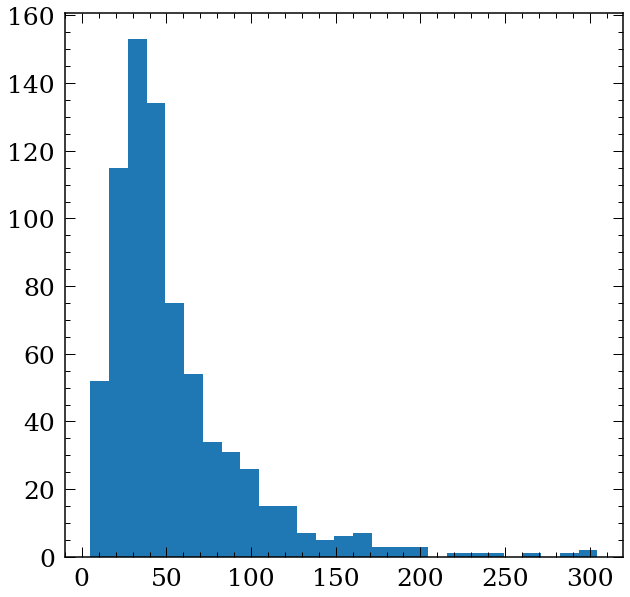

In [28]:
snrs=np.zeros(len(tr_ID))
for i in range(len(tr_ID)):
    snrs[i]=calc_SNR(tr_flux[i,:], tr_ivar[i,:])
plt.hist(snrs,bins=int(np.sqrt(len(tr_ID))))
    

In [ ]:
# get ride of low SNR stars
snrs=np.zeros(len(tr_ID))
for i in range(len(tr_ID)):
    snrs[i]=calc_SNR(tr_flux[i,:], tr_ivar[i,:])
m=snrs>40
tr_ID,tr_flux,tr_ivar,tr_label=tr_ID[m],tr_flux[m,:],tr_ivar[m,:],tr_label[m,:]

print(tr_ID.shape)
print(wl_all.shape)
print(tr_flux.shape)
print(tr_ivar.shape)
print(tr_label.shape)

plt.hist(snrs,bins=int(np.sqrt(len(tr_ID))))

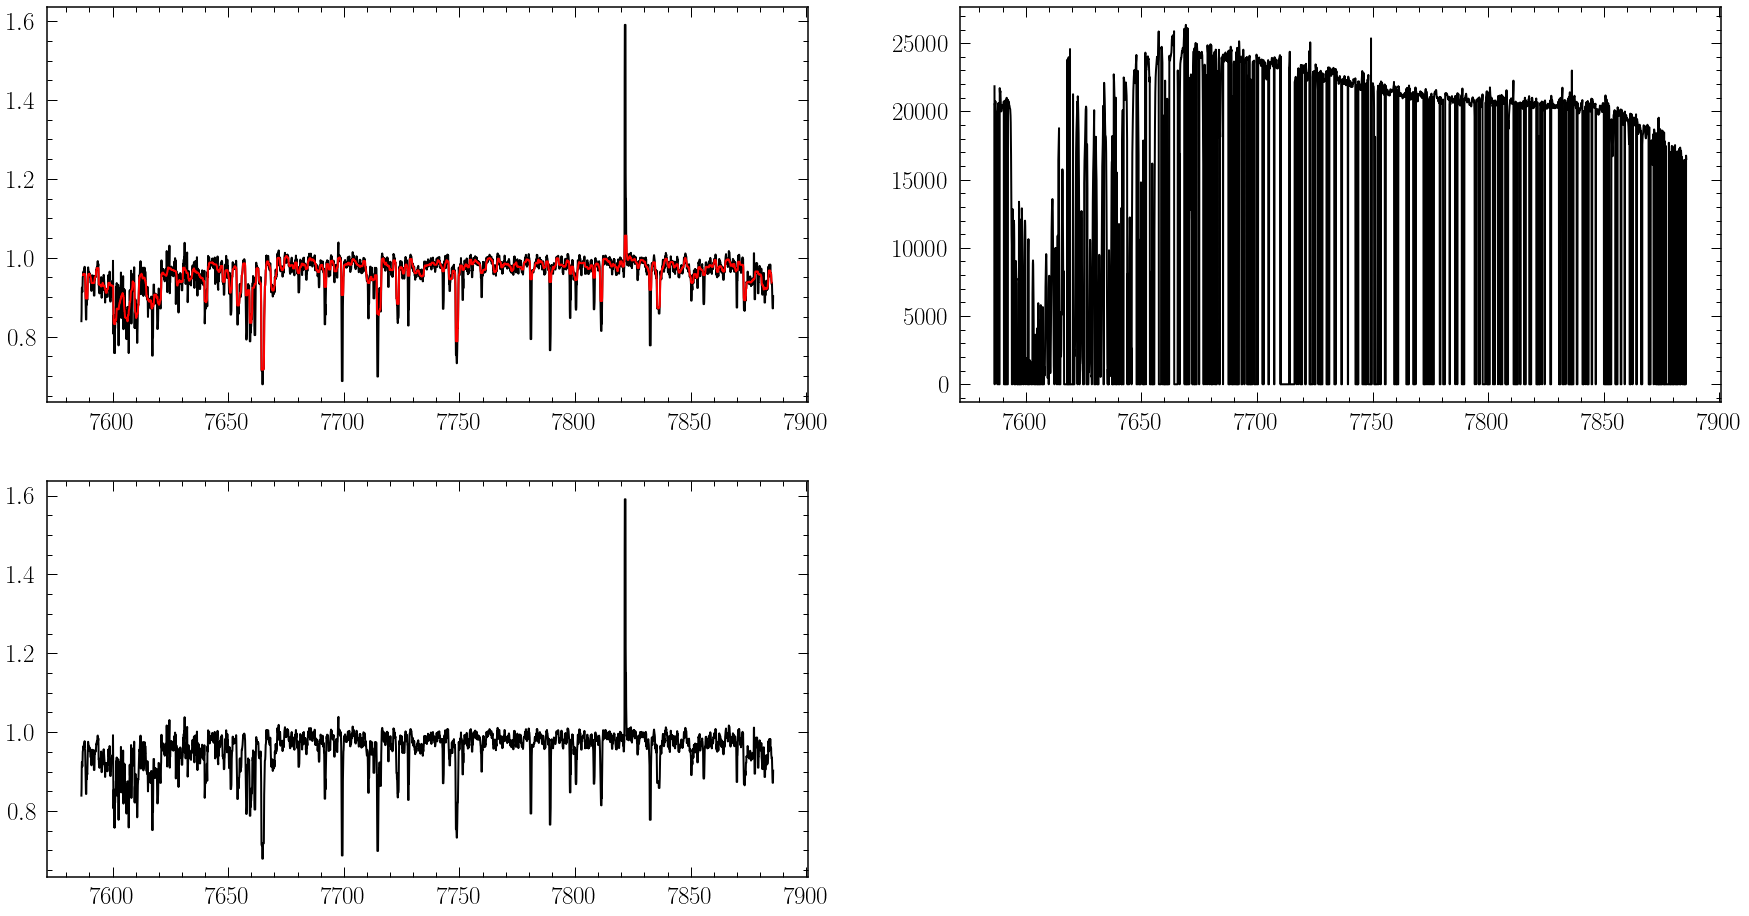

In [520]:
pltnumb=0
softenp=20
# plot one spectra
plt.figure(figsize=(30,16))
plt.subplot(2,2,1)
plt.plot(wl_all,tr_flux[pltnumb,:],'k-')
flux_errs=np.sqrt(1/tr_ivar[pltnumb,:])*tr_flux[pltnumb,:]
normflux,outs=get_outliers(tr_flux[pltnumb,:], flux_errs, softenp=softenp, f=3)
plt.plot(wl_all,normflux,'r-')
plt.plot(wl_all[outs],tr_flux[pltnumb,:][outs],'b.',markersize=15)
#plt.xlim([7820,7830])

plt.subplot(2,2,2)
plt.plot(wl_all,tr_ivar[pltnumb,:],'k-')


plt.subplot(2,2,3)
newflux, fewivar=replace_outliers(tr_flux[pltnumb,:], tr_ivar[pltnumb,:], softenp=softenp, f=3)
plt.plot(wl_all,newflux,'k-')



In [ ]:
for i in range(len(tr_ID)):
    pltnumb=i
    # plot one spectra
    plt.figure(figsize=(30,8))
    plt.subplot(1,2,1)
    plt.plot(wl_all,tr_flux[pltnumb,:],'k-')
    plt.title(str(i))
    #plt.xlim([4600,5000])

    plt.subplot(1,2,2)
    plt.plot(wl_all,tr_ivar[pltnumb,:],'k-')
    
    #plt.yscale('log')
    #plt.yscale('log')
    #plt.savefig(str(i)+'.png')


In [538]:
# get ride of bard stars

badstars=[32,54,178]
tr_ID=np.delete(tr_ID,badstars)
tr_flux=np.delete(tr_flux,badstars,axis=0)
tr_ivar=np.delete(tr_ivar,badstars,axis=0)
tr_label=np.delete(tr_label,badstars,axis=0)

print(tr_ID.shape)
print(wl_all.shape)
print(tr_flux.shape)
print(tr_ivar.shape)
print(tr_label.shape)



(579,)
(4096,)
(579, 4096)
(579, 4096)
(579, 7)


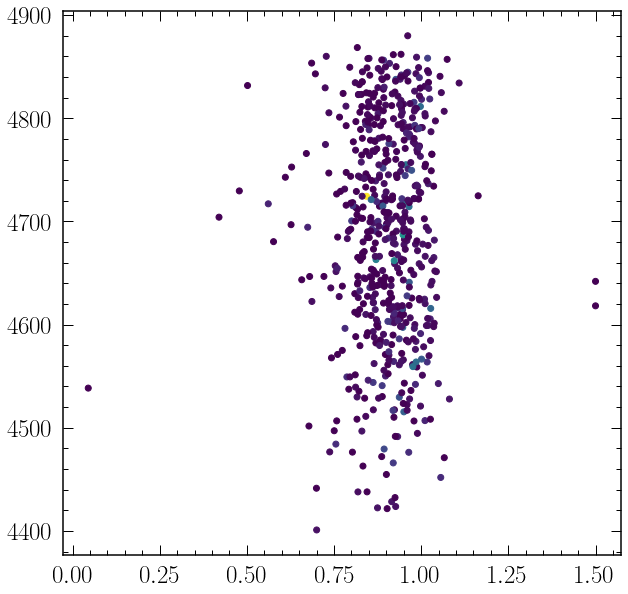

In [539]:
plt.scatter(tr_flux[:,1000],tr_label[:,1],c=tr_ivar[:,1000])


In [540]:
test_ID = tr_ID
test_flux = tr_flux
test_ivar = tr_ivar


In [541]:
from TheCannon import dataset
ds = dataset.Dataset(wl_all, tr_ID, tr_flux, tr_ivar, 
                     tr_label, test_ID, test_flux, test_ivar)

Loading dataset
This may take a while...


In [542]:
ds.set_label_names(labelnames)

Diagnostic for SNRs of reference and survey objects


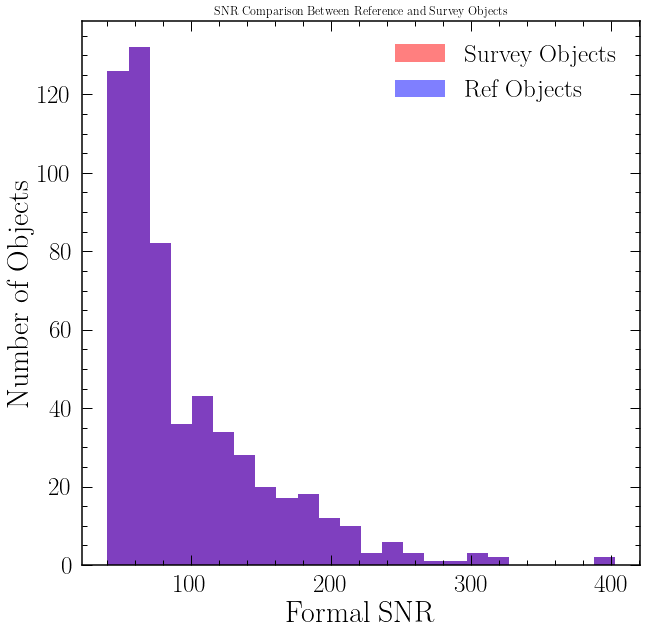

In [543]:
fig = ds.diagnostics_SNR()

In [544]:
from TheCannon import model
md = model.CannonModel(2, useErrors=False)
md.fit(ds)



Done training model. 


In [545]:

md.diagnostics_plot_chisq(ds)


Diagnostic plot: histogram of the red chi squareds of the fit
Saved as modelfit_chisqs.png


In [546]:
label_errs = md.infer_labels(ds)
test_labels = ds.test_label_vals
ds.diagnostics_1to1()



Inferring Labels
Error - curve_fit failed


/opt/homebrew/anaconda3/lib/python3.8/site-packages/TheCannon/infer_labels.py:113: RuntimeWarning: invalid value encountered in sqrt
  errs_all[jj,:] = np.sqrt(covs.diagonal())


Diagnostic for label output vs. input
Saved fig 1to1_label_0.png
Diagnostic for label output vs. input
Saved fig 1to1_label_1.png
Diagnostic for label output vs. input
Saved fig 1to1_label_2.png
Diagnostic for label output vs. input
Saved fig 1to1_label_3.png
Diagnostic for label output vs. input
Saved fig 1to1_label_4.png
Diagnostic for label output vs. input
Saved fig 1to1_label_5.png
Diagnostic for label output vs. input
Saved fig 1to1_label_6.png


Diagnostic plot: leading coeffs and scatters across wavelength.


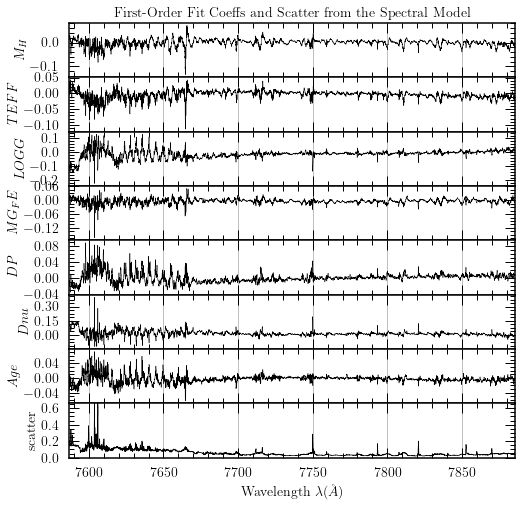

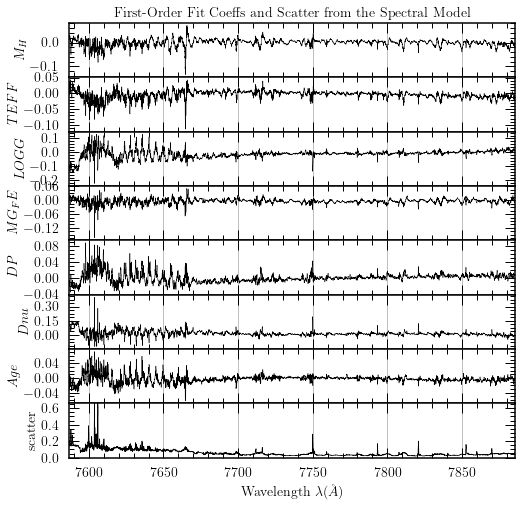

In [547]:
md.diagnostics_leading_coeffs(ds)



In [ ]:
print(np.shape(test_labels))
print(np.shape(tr_label))



In [29]:
import matplotlib.gridspec as gridspec

def diagnostics_1to1_self(df, figname="1to1_label"):
        """ Plots survey labels vs. training labels, color-coded by survey SNR """
        snr = df.test_SNR
        label_names = df.get_plotting_labels()
        nlabels = len(label_names)
        reference_labels = df.tr_label
        test_labels = df.test_label_vals
        
        m=test_labels[:,0]>-100
        reference_labels=reference_labels[m,:]
        test_labels=test_labels[m,:]
        snr=snr[m]

        for i in range(nlabels):
            name = label_names[i]
            orig = reference_labels[:,i]
            cannon = test_labels[:,i]
            # calculate bias and scatter
            scatter = np.round(np.std(orig-cannon),5)
            bias  = np.round(np.mean(orig-cannon),5)

            low = np.minimum(min(orig), min(cannon))
            high = np.maximum(max(orig), max(cannon))

            fig = plt.figure(figsize=(10,6))
            gs = gridspec.GridSpec(1,2,width_ratios=[2,1], wspace=0.3)
            ax1 = plt.subplot(gs[0])
            ax2 = plt.subplot(gs[1])
            ax1.plot([low, high], [low, high], 'k-', linewidth=2.0, label="x=y")
            ax1.set_xlim(low, high)
            ax1.set_ylim(low, high)
            ax1.legend(fontsize=14, loc='lower right')
            pl = ax1.scatter(orig, cannon, marker='x', c=snr,
                    vmin=50, vmax=200, alpha=0.7)
            cb = plt.colorbar(pl, ax=ax1, orientation='horizontal')
            cb.set_label('SNR from Test Set', fontsize=12)
            textstr = 'Scatter: %s \nBias: %s' %(scatter, bias)
            ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes,
                    fontsize=14, verticalalignment='top')
            ax1.tick_params(axis='x', labelsize=14)
            ax1.tick_params(axis='y', labelsize=14)
            ax1.set_xlabel("Reference Value", fontsize=14)
            ax1.set_ylabel("Cannon Test Value", fontsize=14)
            ax1.set_title("1-1 Plot of Label " + r"$%s$" % name)
            diff = cannon-orig
            npoints = len(diff)
            mu = np.mean(diff)
            sig = np.std(diff)
            #ax2.hist(diff, orientation='horizontal')
            ax2.hist(diff, range=[-3*sig,3*sig], color='k', bins=int(np.sqrt(npoints)),
                    orientation='horizontal', alpha=0.3, histtype='stepfilled')
            ax2.tick_params(axis='x', labelsize=14)
            ax2.tick_params(axis='y', labelsize=14)
            ax2.set_xlabel("Count", fontsize=14)
            ax2.set_ylabel("Difference", fontsize=14)
            ax2.axhline(y=0, c='k', lw=3, label='Difference=0')
            ax2.set_title("Training Versus Test Labels for $%s$" %name,
                    fontsize=14)
            ax2.legend(fontsize=14)
            print("Diagnostic for label output vs. input")
            plt.show()

Diagnostic for label output vs. input


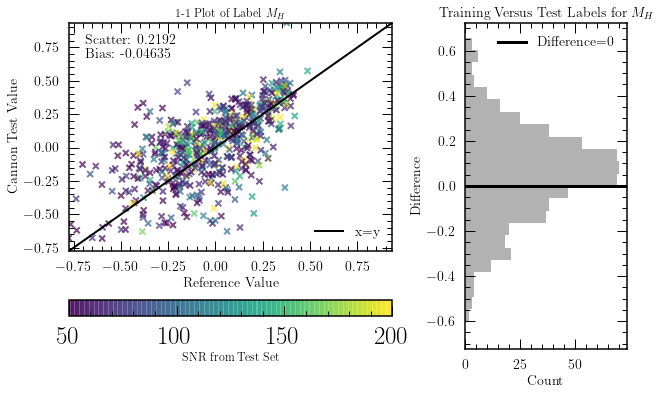

Diagnostic for label output vs. input


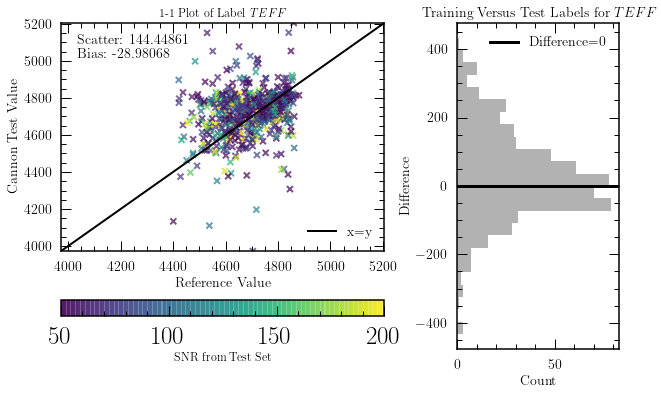

Diagnostic for label output vs. input


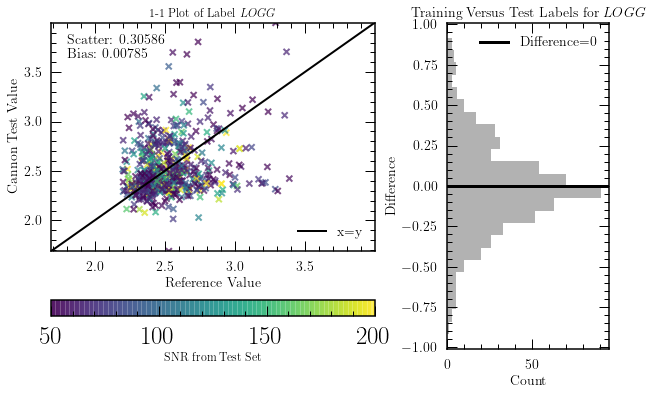

Diagnostic for label output vs. input


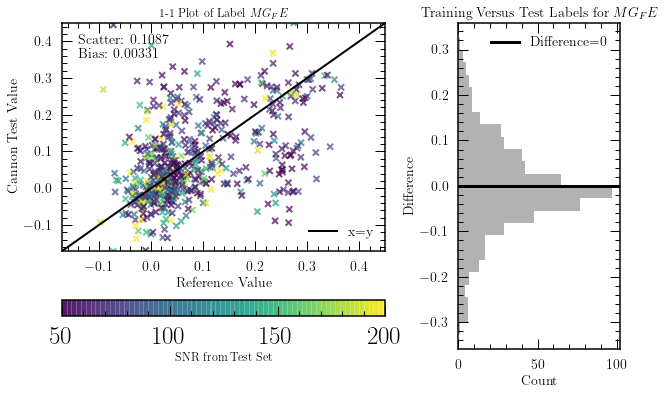

Diagnostic for label output vs. input


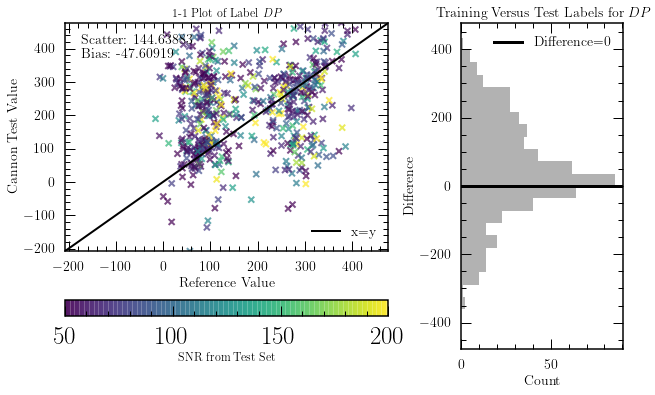

Diagnostic for label output vs. input


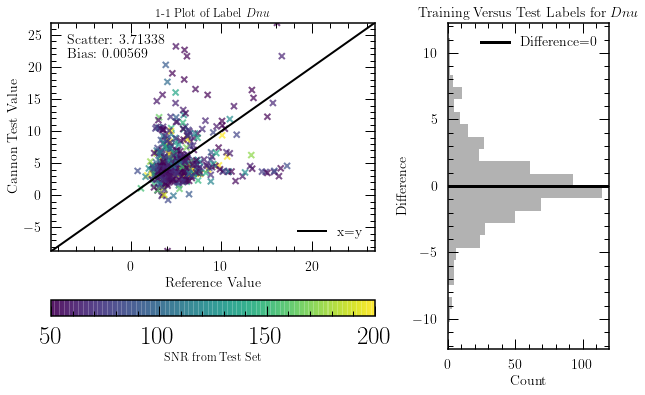

Diagnostic for label output vs. input


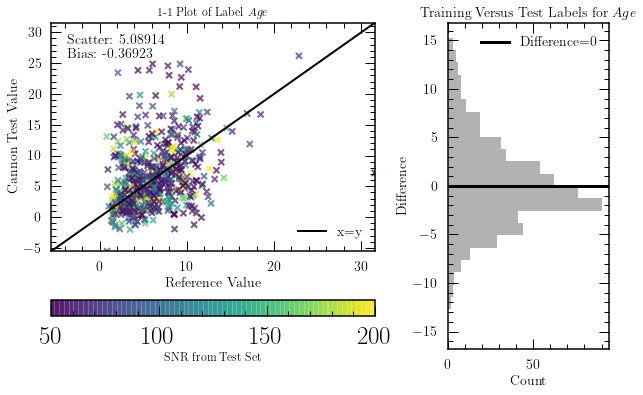

In [595]:
# first cleanup, getting rid of outlisers
diagnostics_1to1_self(ds)

# Train without DP Dnu

In [213]:
tr_ID=useablespec[:,-1]
tr_flux=np.zeros((np.shape(useablespec)[0],4096*4))
tr_ivar=np.zeros((np.shape(useablespec)[0],4096*4))
wl_all=np.zeros(4096*4)

for i in range(4):
    wl_all[4096*i:4096*(i+1)]=wl[:,i]
    
    for j in range(len(tr_ID)):
        tr_flux[j,4096*i:4096*(i+1)]=fluxs[:,i,j]
        tr_ivar[j,4096*i:4096*(i+1)]=abs(ivars[:,i,j])
        
        
m=(wl_all<7586)|(wl_all>7700)
m=m&(wl_all>5000)
m=m&(wl_all<8000)
#m=wl_all>5000
wl_all,tr_flux,tr_ivar=wl_all[m],tr_flux[:,m],tr_ivar[:,m]

In [214]:
len(wl_all)

10734

In [215]:
# get training labels from APOGEE
# get the dataframe for labels not including Dp Dnu
labels=galah_apogee.loc[pd.DataFrame(spec).dropna().index]

cannonage=pd.read_pickle('../SecondYear/CannonDR16.pkl')
labels=labels.merge(cannonage[['APOGEE_ID','Age']], left_on='APOGEE_ID',right_on='APOGEE_ID',how="inner")


labelnames=['M_H','TEFF','LOGG','MG_FE','Age']

tr_label=labels[labelnames].values




In [216]:
"""
i=3
wl_all=wl_all[4096*i:4096*(i+1)]
tr_flux=tr_flux[:,4096*i:4096*(i+1)]
tr_ivar=tr_ivar[:,4096*i:4096*(i+1)]
"""




'\ni=3\nwl_all=wl_all[4096*i:4096*(i+1)]\ntr_flux=tr_flux[:,4096*i:4096*(i+1)]\ntr_ivar=tr_ivar[:,4096*i:4096*(i+1)]\n'

In [217]:
print(tr_ID.shape)
print(wl_all.shape)
print(tr_flux.shape)
print(tr_ivar.shape)
print(tr_label.shape)



(745,)
(10734,)
(745, 10734)
(745, 10734)
(745, 5)


(array([ 53., 161., 185., 107.,  69.,  40.,  30.,  29.,  17.,  14.,   8.,
          9.,   5.,   4.,   3.,   1.,   1.,   1.,   0.,   3.,   1.,   0.,
          1.,   1.,   0.,   1.,   1.]),
 array([  5.76761219,  21.55676009,  37.34590799,  53.13505589,
         68.92420379,  84.71335169, 100.50249959, 116.2916475 ,
        132.0807954 , 147.8699433 , 163.6590912 , 179.4482391 ,
        195.237387  , 211.0265349 , 226.8156828 , 242.6048307 ,
        258.3939786 , 274.1831265 , 289.9722744 , 305.76142231,
        321.55057021, 337.33971811, 353.12886601, 368.91801391,
        384.70716181, 400.49630971, 416.28545761, 432.07460551]),
 <BarContainer object of 27 artists>)

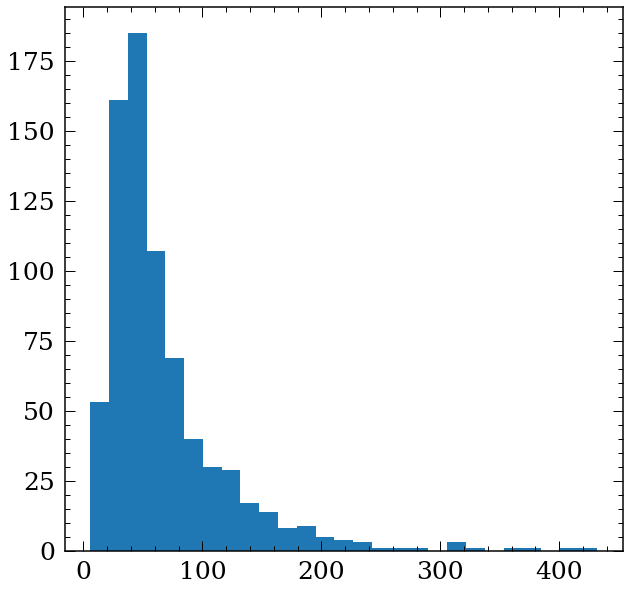

In [218]:
snrs=np.zeros(len(tr_ID))
for i in range(len(tr_ID)):
    snrs[i]=calc_SNR(tr_flux[i,:], tr_ivar[i,:])
plt.hist(snrs,bins=int(np.sqrt(len(tr_ID))))
    

(504,)
(10734,)
(504, 10734)
(504, 10734)
(504, 5)


(array([ 78., 221., 172., 101.,  45.,  41.,  28.,  17.,  11.,   9.,   6.,
          5.,   1.,   1.,   1.,   1.,   3.,   0.,   1.,   1.,   1.,   1.]),
 array([  5.76761219,  25.14520279,  44.5227934 ,  63.90038401,
         83.27797461, 102.65556522, 122.03315582, 141.41074643,
        160.78833703, 180.16592764, 199.54351825, 218.92110885,
        238.29869946, 257.67629006, 277.05388067, 296.43147127,
        315.80906188, 335.18665248, 354.56424309, 373.9418337 ,
        393.3194243 , 412.69701491, 432.07460551]),
 <BarContainer object of 22 artists>)

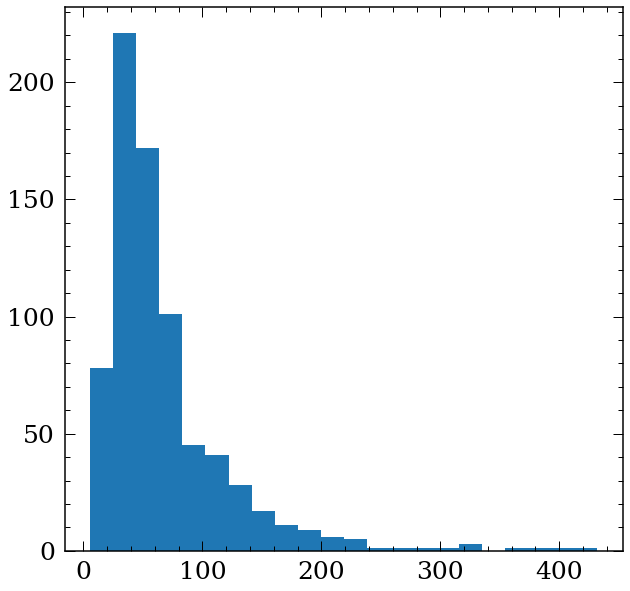

In [219]:
# get ride of low SNR stars
snrs=np.zeros(len(tr_ID))
for i in range(len(tr_ID)):
    snrs[i]=calc_SNR(tr_flux[i,:], tr_ivar[i,:])
m=snrs>40
tr_ID,tr_flux,tr_ivar,tr_label=tr_ID[m],tr_flux[m,:],tr_ivar[m,:],tr_label[m,:]

print(tr_ID.shape)
print(wl_all.shape)
print(tr_flux.shape)
print(tr_ivar.shape)
print(tr_label.shape)

plt.hist(snrs,bins=int(np.sqrt(len(tr_ID))))

In [222]:
test_ID = tr_ID
test_flux = tr_flux
test_ivar = tr_ivar



In [223]:
from TheCannon import dataset
ds = dataset.Dataset(wl_all, tr_ID, tr_flux, tr_ivar, 
                     tr_label, test_ID, test_flux, test_ivar)

Loading dataset
This may take a while...


In [224]:
ds.set_label_names(labelnames)

Diagnostic for SNRs of reference and survey objects


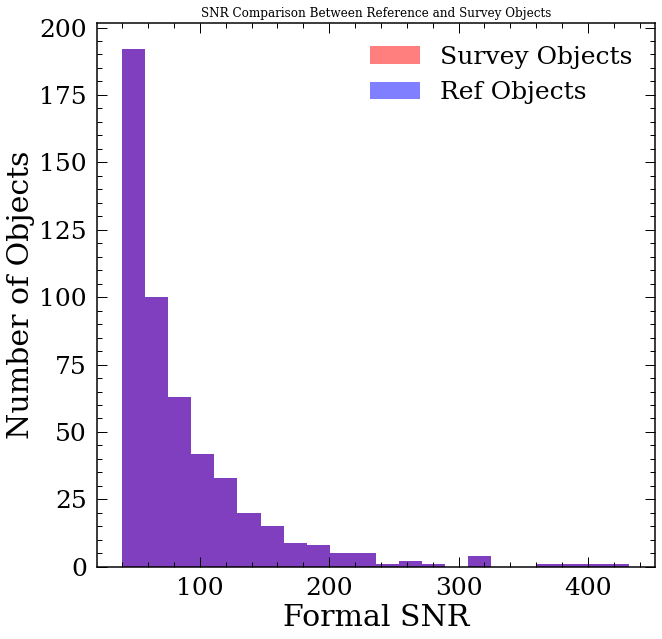

In [225]:
fig = ds.diagnostics_SNR()

In [226]:
from TheCannon import model
md = model.CannonModel(2, useErrors=False)
md.fit(ds)


Done training model. 


Inferring Labels
Diagnostic plot: leading coeffs and scatters across wavelength.


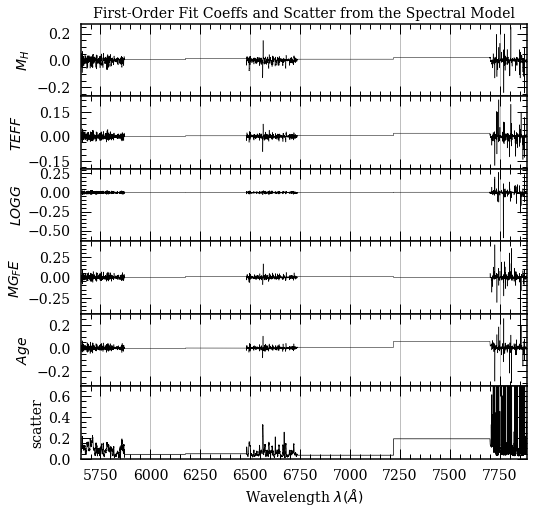

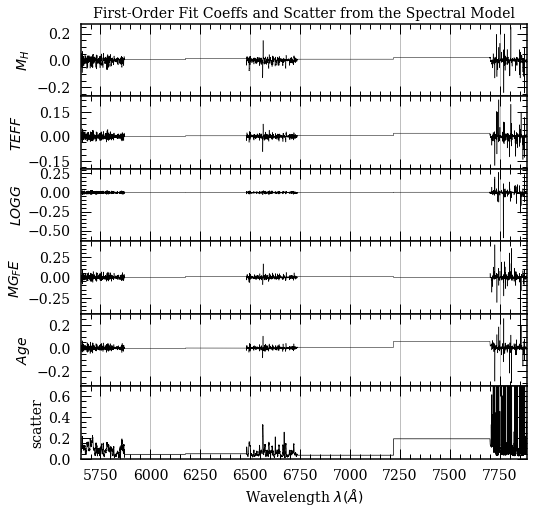

In [227]:
label_errs = md.infer_labels(ds)
test_labels = ds.test_label_vals
md.diagnostics_leading_coeffs(ds)



In [228]:
import matplotlib.gridspec as gridspec

def diagnostics_1to1_self(df, figname="1to1_label"):
        """ Plots survey labels vs. training labels, color-coded by survey SNR """
        snr = df.test_SNR
        label_names = df.get_plotting_labels()
        nlabels = len(label_names)
        reference_labels = df.tr_label
        test_labels = df.test_label_vals
        
        m=test_labels[:,-1]<15
        reference_labels=reference_labels[m,:]
        test_labels=test_labels[m,:]
        snr=snr[m]
        
        m=test_labels[:,0]>-100
        reference_labels=reference_labels[m,:]
        test_labels=test_labels[m,:]
        snr=snr[m]

        for i in range(nlabels):
            name = label_names[i]
            orig = reference_labels[:,i]
            cannon = test_labels[:,i]
            # calculate bias and scatter
            scatter = np.round(np.std(orig-cannon),5)
            bias  = np.round(np.mean(orig-cannon),5)

            low = np.minimum(min(orig), min(cannon))
            high = np.maximum(max(orig), max(cannon))

            fig = plt.figure(figsize=(10,6))
            gs = gridspec.GridSpec(1,2,width_ratios=[2,1], wspace=0.3)
            ax1 = plt.subplot(gs[0])
            ax2 = plt.subplot(gs[1])
            ax1.plot([low, high], [low, high], 'k-', linewidth=2.0, label="x=y")
            ax1.set_xlim(low, high)
            ax1.set_ylim(low, high)
            ax1.legend(fontsize=14, loc='lower right')
            pl = ax1.scatter(orig, cannon, marker='x', c=snr,
                    vmin=50, vmax=200, alpha=0.7)
            cb = plt.colorbar(pl, ax=ax1, orientation='horizontal')
            cb.set_label('SNR from Test Set', fontsize=12)
            textstr = 'Scatter: %s \nBias: %s' %(scatter, bias)
            ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes,
                    fontsize=14, verticalalignment='top')
            ax1.tick_params(axis='x', labelsize=14)
            ax1.tick_params(axis='y', labelsize=14)
            ax1.set_xlabel("Reference Value", fontsize=14)
            ax1.set_ylabel("Cannon Test Value", fontsize=14)
            ax1.set_title("1-1 Plot of Label " + r"$%s$" % name)
            diff = cannon-orig
            npoints = len(diff)
            mu = np.mean(diff)
            sig = np.std(diff)
            #ax2.hist(diff, orientation='horizontal')
            ax2.hist(diff, range=[-3*sig,3*sig], color='k', bins=int(np.sqrt(npoints)),
                    orientation='horizontal', alpha=0.3, histtype='stepfilled')
            ax2.tick_params(axis='x', labelsize=14)
            ax2.tick_params(axis='y', labelsize=14)
            ax2.set_xlabel("Count", fontsize=14)
            ax2.set_ylabel("Difference", fontsize=14)
            ax2.axhline(y=0, c='k', lw=3, label='Difference=0')
            ax2.set_title("Training Versus Test Labels for $%s$" %name,
                    fontsize=14)
            ax2.legend(fontsize=14)
            print("Diagnostic for label output vs. input")
            plt.show()

Diagnostic for label output vs. input


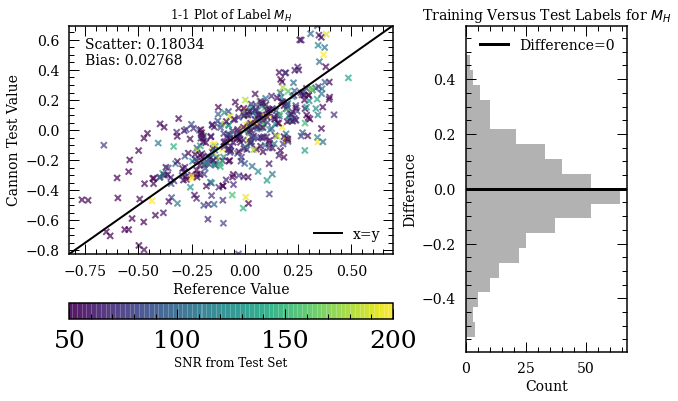

Diagnostic for label output vs. input


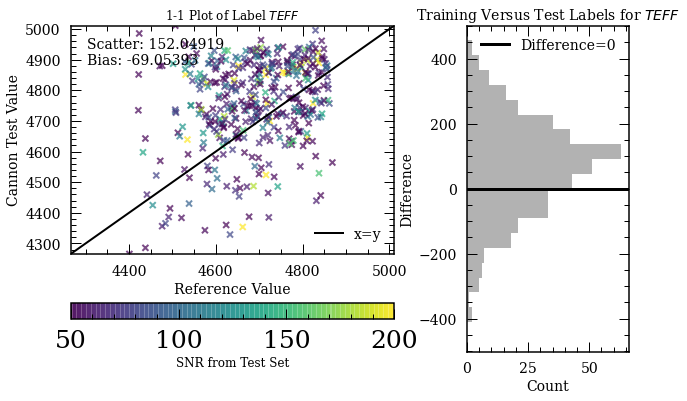

Diagnostic for label output vs. input


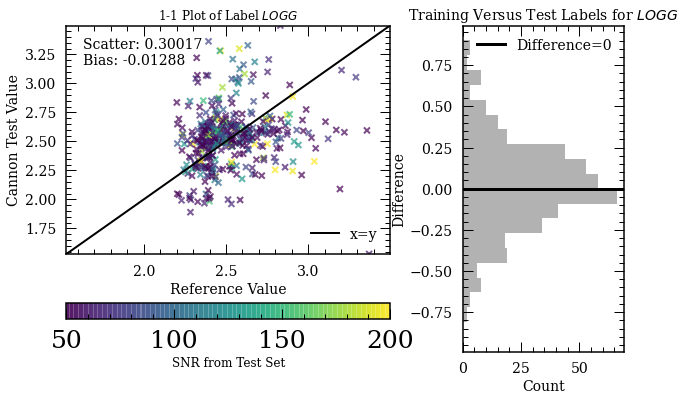

Diagnostic for label output vs. input


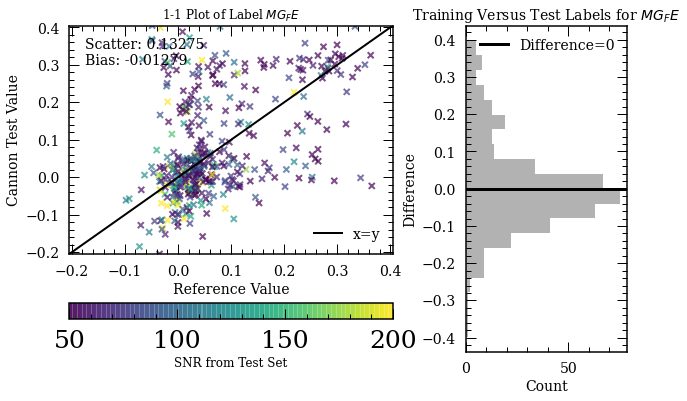

Diagnostic for label output vs. input


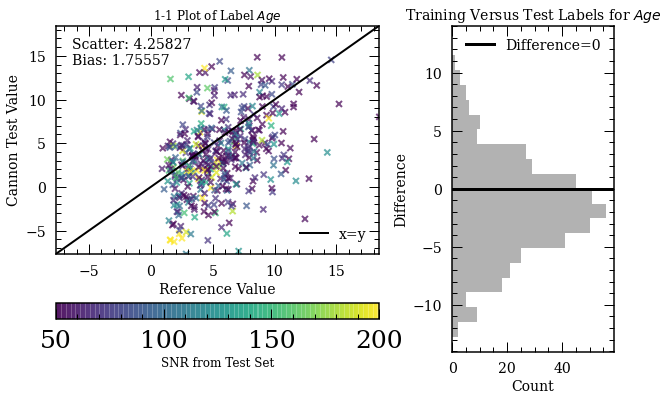

In [229]:
# first cleanup, getting rid of outlisers
diagnostics_1to1_self(ds)




6480.07763671871 6734.878103417812
6480.07763671871 6734.878103417812
6480.07763671871 6734.878103417812
6480.07763671871 6734.878103417812
6480.07763671871 6734.878103417812


Text(0, 0.5, 'scatter')

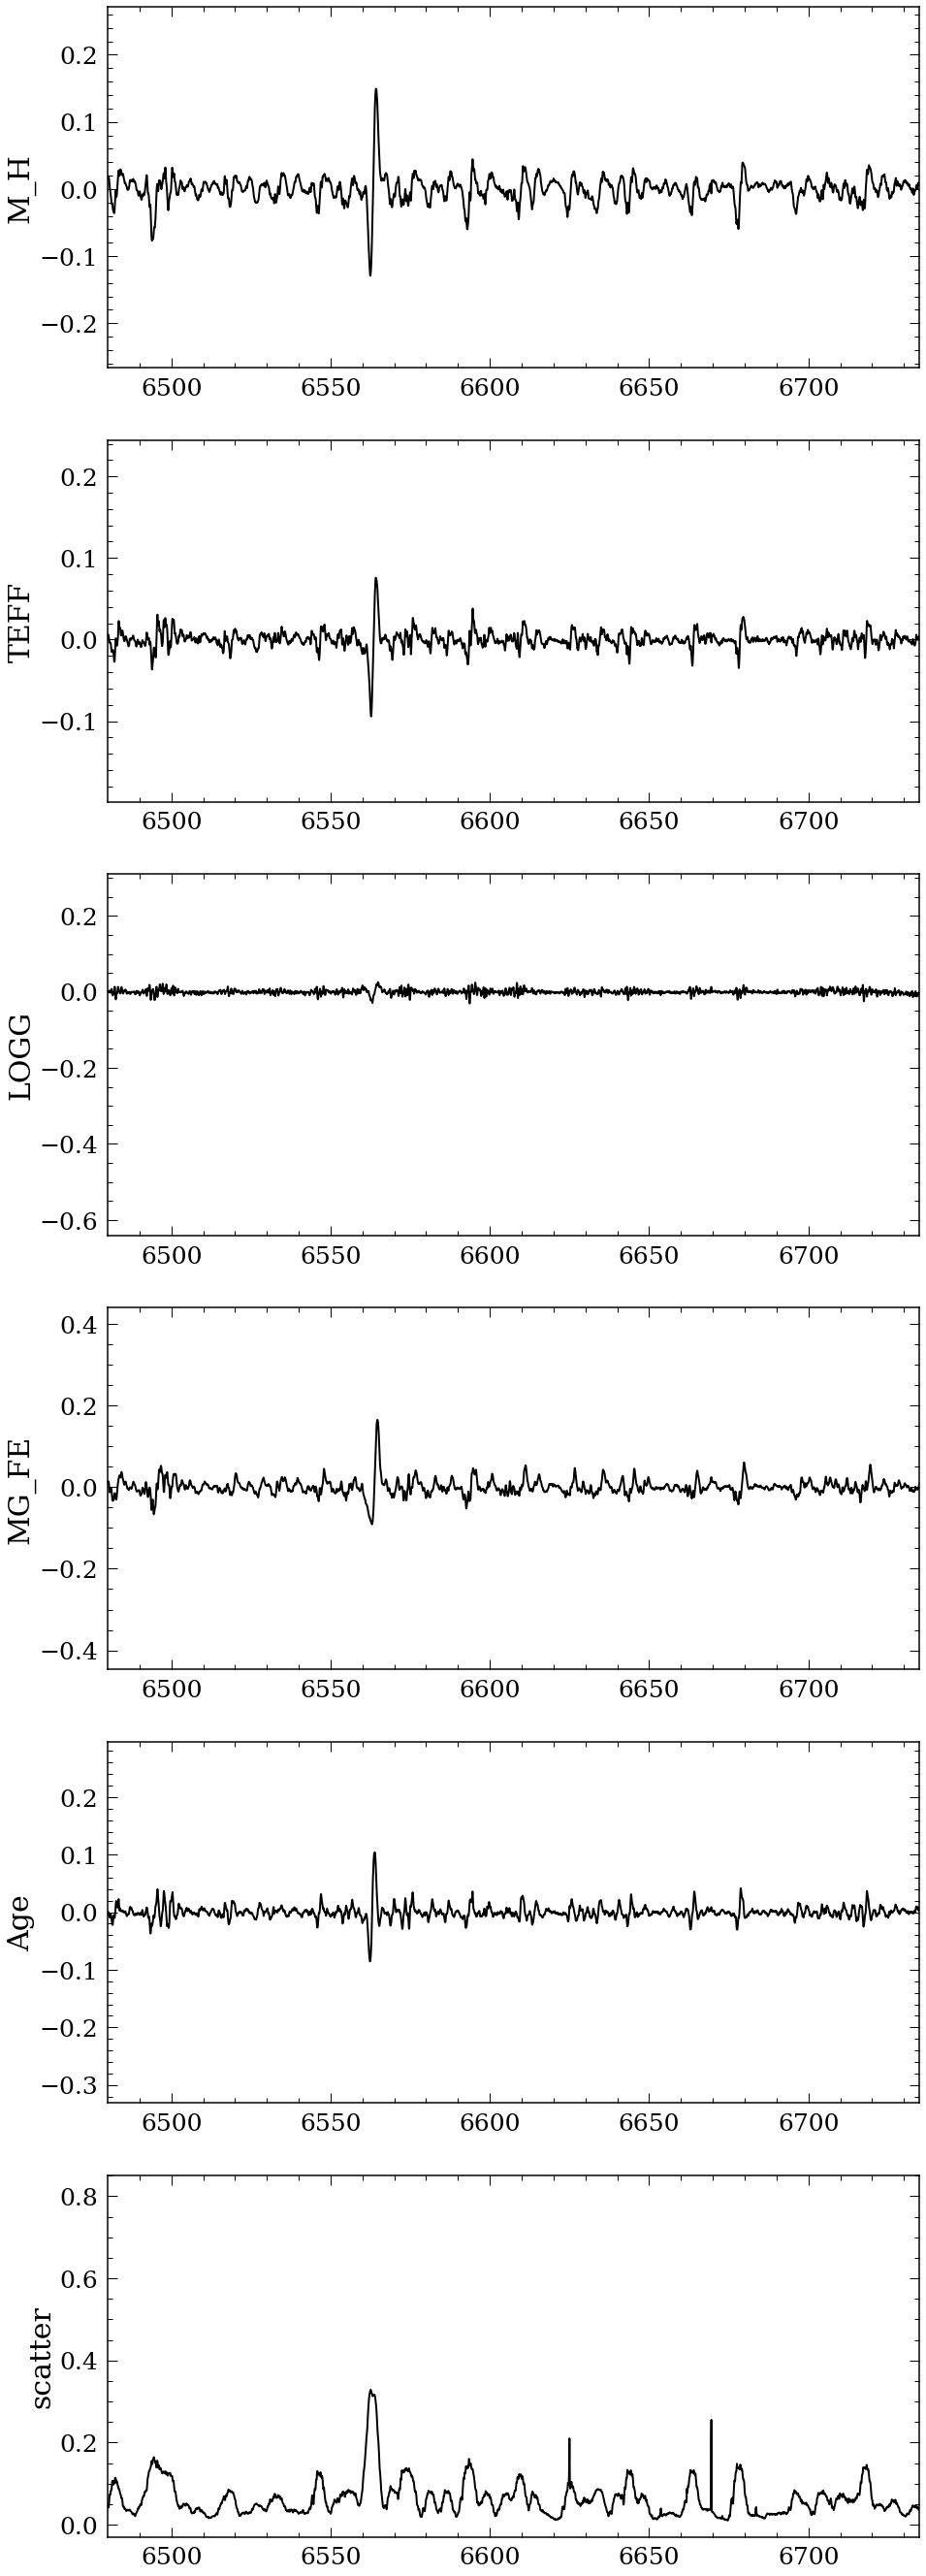

In [230]:
plt.rcParams.keys()
plt.rc('font', family='serif')
params = {'text.usetex': False}
plt.rcParams.update(params)

rangecheck=2

labels_pltt=ds.get_plotting_labels()
plt.figure(figsize=(15,48))
coefs=md.coeffs
for i in range(5):
    coef=coefs[:,i+1]
    plt.subplot(6,1,i+1)
    for j in range(4):
        wlsing=wl_all[4096*j:4096*(j+1)]
        coef_wl=coef[4096*j:4096*(j+1)]
        plt.plot(wlsing,coef_wl,'k-')
        if j+1==rangecheck:
            minwl=min(wlsing)
            maxwl=max(wlsing)
            print(minwl,maxwl)
            plt.xlim([min(wlsing),max(wlsing)])
            
    plt.ylabel(labels_pltt[i])
    
plt.subplot(6,1,6)
plt.plot(wl_all,md.scatters,'k-')
plt.xlim([minwl,maxwl])
plt.ylabel('scatter')

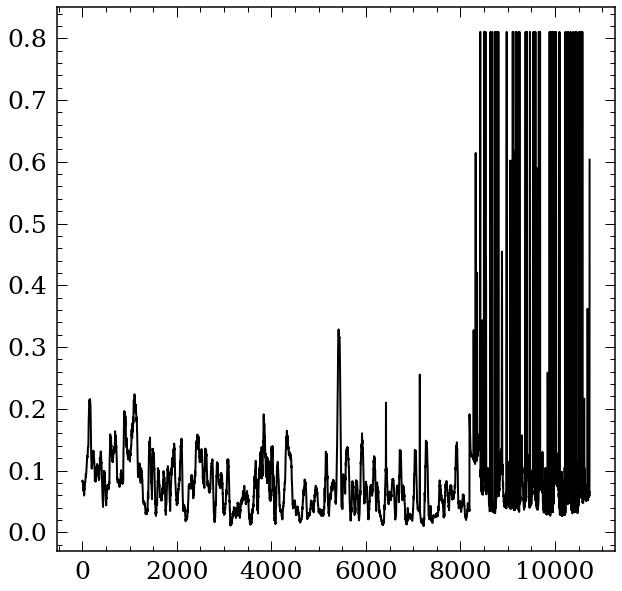

In [231]:
plt.plot(md.scatters,'k-')

In [232]:
linlist=pd.read_table('Data/linetable',delimiter=',',skiprows=1)
linlist['wl1']=(linlist['starting wl']>min(wl_all[:4096]))&(linlist['endingwl']<max(wl_all[:4096]))
linlist['wl2']=(linlist['starting wl']>(min(wl_all[4096:4096*2])))&(linlist['endingwl']<max(wl_all[4096:4096*2]))
linlist['wl3']=(linlist['starting wl']>min(wl_all[4096*2:]))&(linlist['endingwl']<max(wl_all[4096*2:]))
linlist['width']=linlist['endingwl']-linlist['starting wl']
linlist

element  starting wl  endingwl    wl1    wl2    wl3  width
0        Al      6695.78   6696.17  False   True  False   0.39
1        Al      6698.41   6698.92  False   True  False   0.51
2        Al      7834.95   7835.47  False  False   True   0.52
3        Al      7835.84   7836.43  False  False   True   0.59
4        Ba      5853.53   5853.86   True  False  False   0.33
..      ...          ...       ...    ...    ...    ...    ...
104       Y      4883.54   4883.82  False  False  False   0.28
105       Y      5662.74   5663.18   True  False  False   0.44
106       Y      5728.74   5729.01   True  False  False   0.27
107      Zn      4721.99   4722.27  False  False  False   0.28
108      Zn      4810.36   4810.63  False  False  False   0.27

[109 rows x 7 columns]

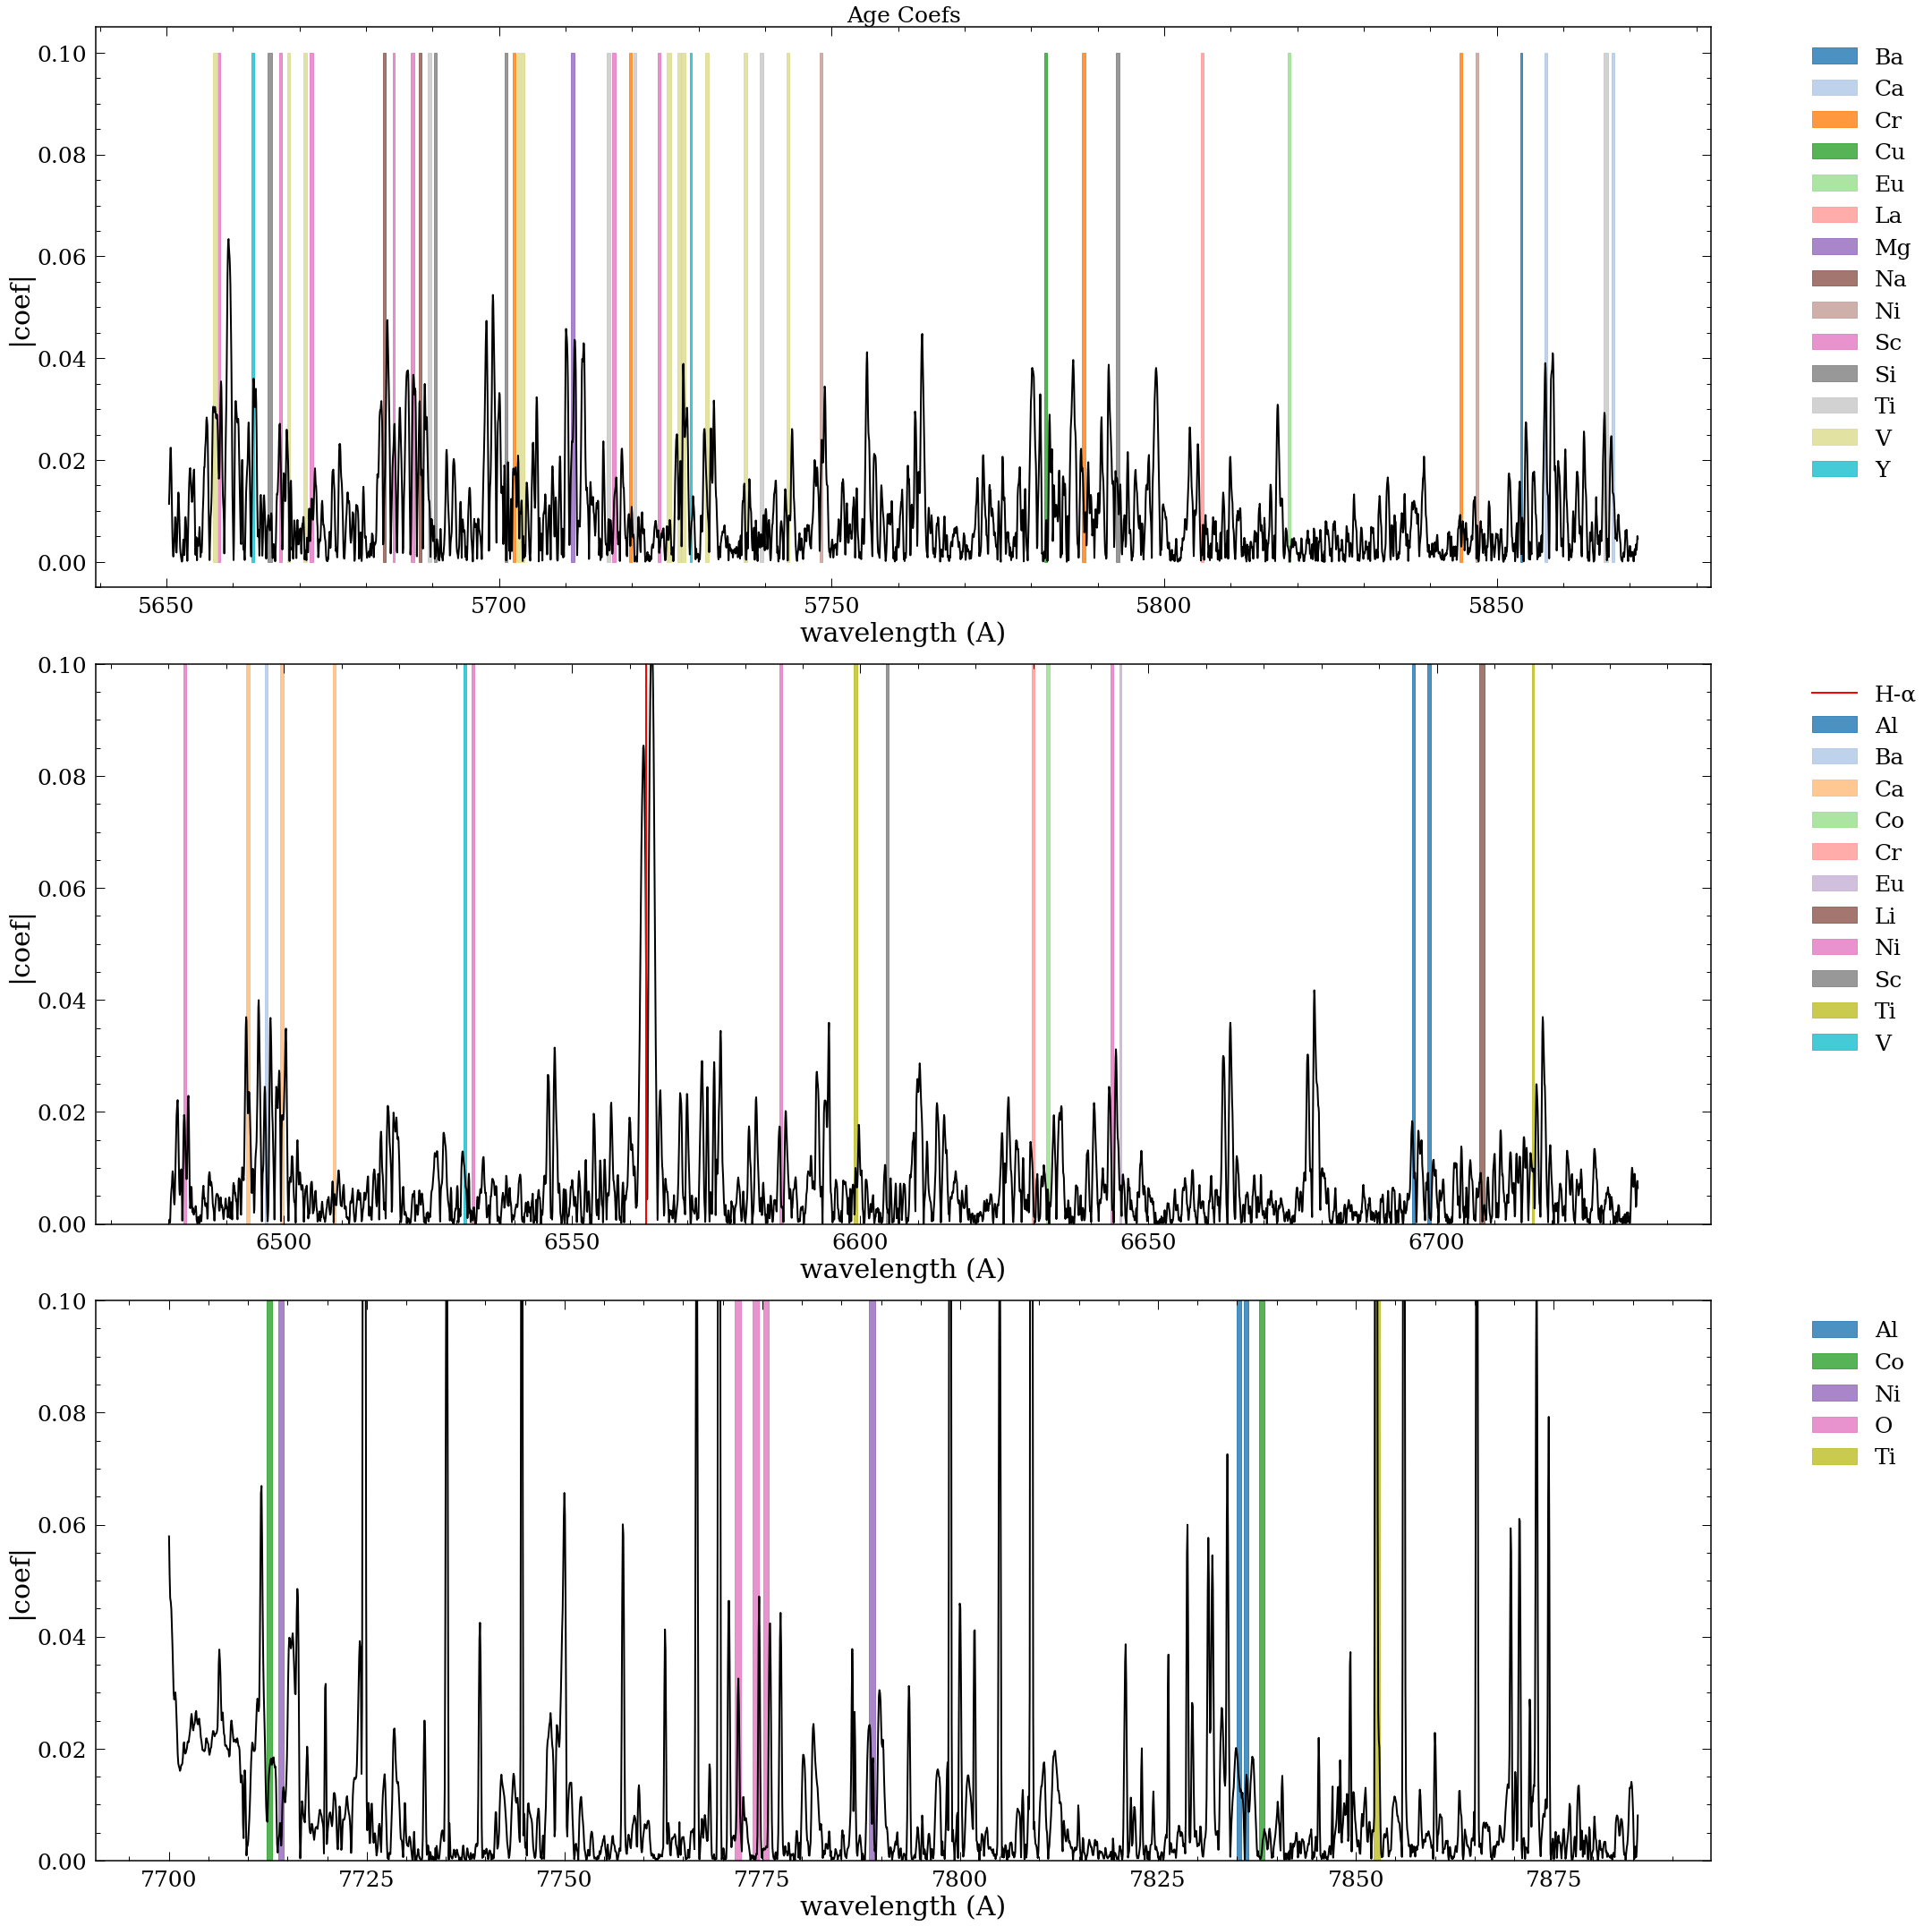

In [233]:
import matplotlib.patches as mpatches
import random

linnumb=5

plt.figure(figsize=(30,30))
plt.subplot(3,1,1)
plt.plot(wl_all[:4096],abs(coefs[:,linnumb][:4096]),'k-')
linwl1=linlist.loc[linlist['wl1']==1].reset_index(drop=True)
elemts=linwl1.element.unique()
for i in range(len(elemts)):
    linwl1_ele=linwl1.loc[linwl1['element']==elemts[i]].reset_index(drop=True)
    colorele=plt.cm.tab20(i/len(elemts))
    for j in range(len(linwl1_ele)):
        if j==0:
            rect=mpatches.Rectangle([linwl1_ele['starting wl'].iloc[j],0],linwl1_ele['width'].iloc[j],0.1,
                               alpha=0.8,color=colorele,label=elemts[i])
        else:
            rect=mpatches.Rectangle([linwl1_ele['starting wl'].iloc[j],0],linwl1_ele['width'].iloc[j],0.1,
                               alpha=0.8,color=colorele)
        plt.gca().add_patch(rect)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('|coef|')
plt.xlabel('wavelength (A)')
plt.title('Age Coefs',fontsize=25)
#plt.ylim([0,0.1])
#plt.xlim([5680,5690])

plt.subplot(3,1,2)
linwl1=linlist.loc[linlist['wl2']==1].reset_index(drop=True)
elemts=linwl1.element.unique()
for i in range(len(elemts)):
    linwl1_ele=linwl1.loc[linwl1['element']==elemts[i]].reset_index(drop=True)
    colorele=plt.cm.tab20(i/len(elemts))
    for j in range(len(linwl1_ele)):
        if j==0:
            rect=mpatches.Rectangle([linwl1_ele['starting wl'].iloc[j],0],linwl1_ele['width'].iloc[j],0.1,
                               alpha=0.8,color=colorele,label=elemts[i])
        else:
            rect=mpatches.Rectangle([linwl1_ele['starting wl'].iloc[j],0],linwl1_ele['width'].iloc[j],0.1,
                               alpha=0.8,color=colorele)
        plt.gca().add_patch(rect)
plt.plot(wl_all[4096:4096*2],abs(coefs[:,linnumb][4096:4096*2]),'k-')
#plt.plot(wl_all[4096:4096*2],abs(coefs[:,5][4096:4096*2]),'k-')
plt.plot([6562.8,6562.8],[0,1],'r-',linewidth=2,label='H-α')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('|coef|')
plt.xlabel('wavelength (A)')
plt.ylim([0,0.1])
#plt.xlim([6550,6570])

plt.subplot(3,1,3)
linwl1=linlist.loc[linlist['wl3']==1].reset_index(drop=True)
elemts=linwl1.element.unique()
for i in range(len(elemts)):
    linwl1_ele=linwl1.loc[linwl1['element']==elemts[i]].reset_index(drop=True)
    colorele=plt.cm.tab20(i/len(elemts))
    for j in range(len(linwl1_ele)):
        if j==0:
            rect=mpatches.Rectangle([linwl1_ele['starting wl'].iloc[j],0],linwl1_ele['width'].iloc[j],0.1,
                               alpha=0.8,color=colorele,label=elemts[i])
        else:
            rect=mpatches.Rectangle([linwl1_ele['starting wl'].iloc[j],0],linwl1_ele['width'].iloc[j],0.1,
                               alpha=0.8,color=colorele)
        plt.gca().add_patch(rect)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.plot(wl_all[4096*2:],abs(coefs[:,linnumb][4096*2:]),'k-')
plt.ylabel('|coef|')
plt.xlabel('wavelength (A)')
plt.ylim([0,0.1])

plt.tight_layout()

plt.savefig('agecoef.png')

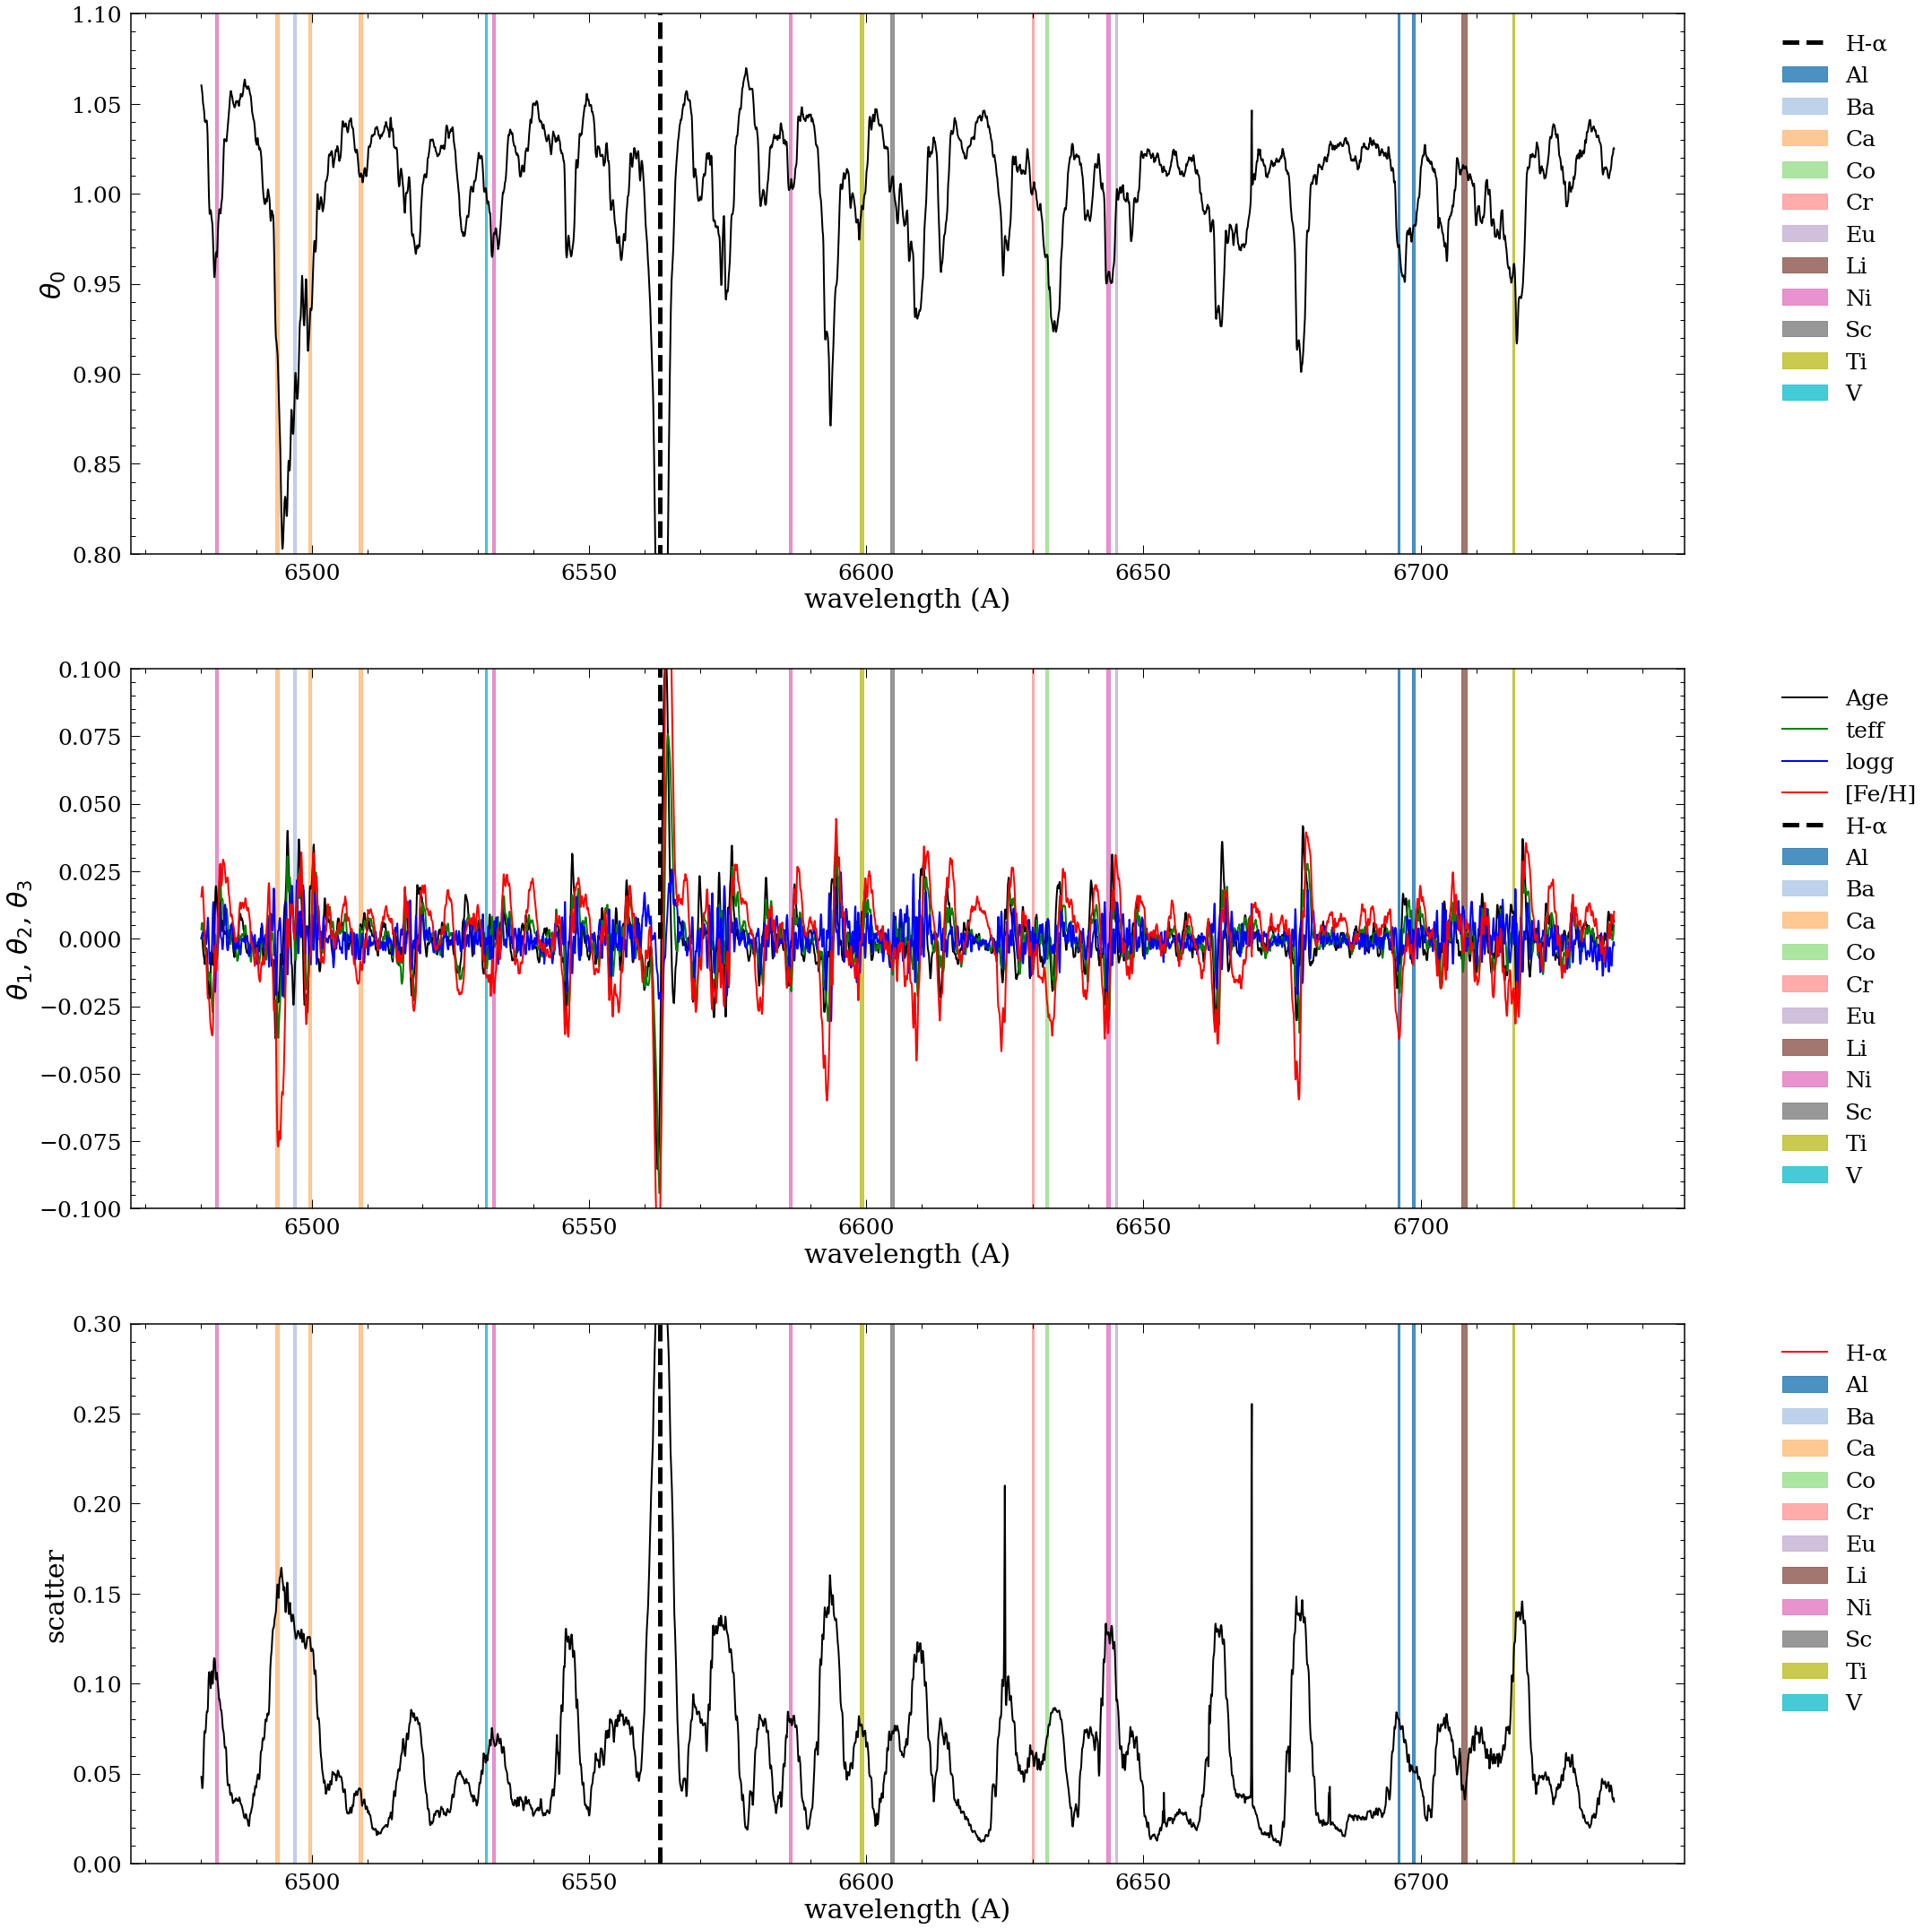

In [234]:
# All coeffs
import matplotlib.patches as mpatches
import random

linnumb=5
wavelenghlim=[6560,6570]
wavelenghlim=[]

plt.figure(figsize=(30,30))
plt.subplot(3,1,1)
plt.plot(wl_all[4096:4096*2],abs(coefs[:,0][4096:4096*2]),'k-')
linwl1=linlist.loc[linlist['wl2']==1].reset_index(drop=True)
elemts=linwl1.element.unique()
for i in range(len(elemts)):
    linwl1_ele=linwl1.loc[linwl1['element']==elemts[i]].reset_index(drop=True)
    colorele=plt.cm.tab20(i/len(elemts))
    for j in range(len(linwl1_ele)):
        if j==0:
            rect=mpatches.Rectangle([linwl1_ele['starting wl'].iloc[j],0.7],linwl1_ele['width'].iloc[j],0.4,
                               alpha=0.8,color=colorele,label=elemts[i])
        else:
            rect=mpatches.Rectangle([linwl1_ele['starting wl'].iloc[j],0.7],linwl1_ele['width'].iloc[j],0.4,
                               alpha=0.8,color=colorele)
        plt.gca().add_patch(rect)
plt.plot([6562.8,6562.8],[0.4,1.1],'k--',linewidth=5,label='H-α')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('$θ_0$')
plt.xlabel('wavelength (A)')
plt.ylim([0.8,1.1])
if len(wavelenghlim)!=0:
    plt.xlim(wavelenghlim)

plt.subplot(3,1,2)
# age
linwl1=linlist.loc[linlist['wl2']==1].reset_index(drop=True)
elemts=linwl1.element.unique()
for i in range(len(elemts)):
    linwl1_ele=linwl1.loc[linwl1['element']==elemts[i]].reset_index(drop=True)
    colorele=plt.cm.tab20(i/len(elemts))
    for j in range(len(linwl1_ele)):
        if j==0:
            rect=mpatches.Rectangle([linwl1_ele['starting wl'].iloc[j],-0.1],linwl1_ele['width'].iloc[j],0.2,
                               alpha=0.8,color=colorele,label=elemts[i])
        else:
            rect=mpatches.Rectangle([linwl1_ele['starting wl'].iloc[j],-0.1],linwl1_ele['width'].iloc[j],0.2,
                               alpha=0.8,color=colorele)
        plt.gca().add_patch(rect)
plt.plot(wl_all[4096:4096*2],(coefs[:,linnumb][4096:4096*2]),'k-',label='Age')
plt.plot(wl_all[4096:4096*2],(coefs[:,2][4096:4096*2]),'g-',label='teff')
plt.plot(wl_all[4096:4096*2],(coefs[:,3][4096:4096*2]),'b-',label='logg')
plt.plot(wl_all[4096:4096*2],(coefs[:,1][4096:4096*2]),'r-',label='[Fe/H]')
plt.plot([6562.8,6562.8],[0,1],'k--',linewidth=5,label='H-α')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('$θ_1$, $θ_2$, $θ_3$')
plt.xlabel('wavelength (A)')
plt.ylim([-0.1,0.1])
if len(wavelenghlim)!=0:
    plt.xlim(wavelenghlim)


plt.subplot(3,1,3)
plt.plot(wl_all[4096:4096*2],md.scatters[4096:4096*2],'k-')
linwl1=linlist.loc[linlist['wl2']==1].reset_index(drop=True)
elemts=linwl1.element.unique()
for i in range(len(elemts)):
    linwl1_ele=linwl1.loc[linwl1['element']==elemts[i]].reset_index(drop=True)
    colorele=plt.cm.tab20(i/len(elemts))
    for j in range(len(linwl1_ele)):
        if j==0:
            rect=mpatches.Rectangle([linwl1_ele['starting wl'].iloc[j],0],linwl1_ele['width'].iloc[j],0.3,
                               alpha=0.8,color=colorele,label=elemts[i])
        else:
            rect=mpatches.Rectangle([linwl1_ele['starting wl'].iloc[j],0],linwl1_ele['width'].iloc[j],0.3,
                               alpha=0.8,color=colorele)
        plt.gca().add_patch(rect)
plt.plot([6562.8,6562.8],[0.4,1.1],'r-',linewidth=2,label='H-α')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('scatter')
plt.xlabel('wavelength (A)')
plt.ylim([0,0.3])
plt.plot([6562.8,6562.8],[0,1],'k--',linewidth=5,label='H-α')
if len(wavelenghlim)!=0:
    plt.xlim(wavelenghlim)
    
plt.tight_layout()
plt.savefig('allwavelength2.png')



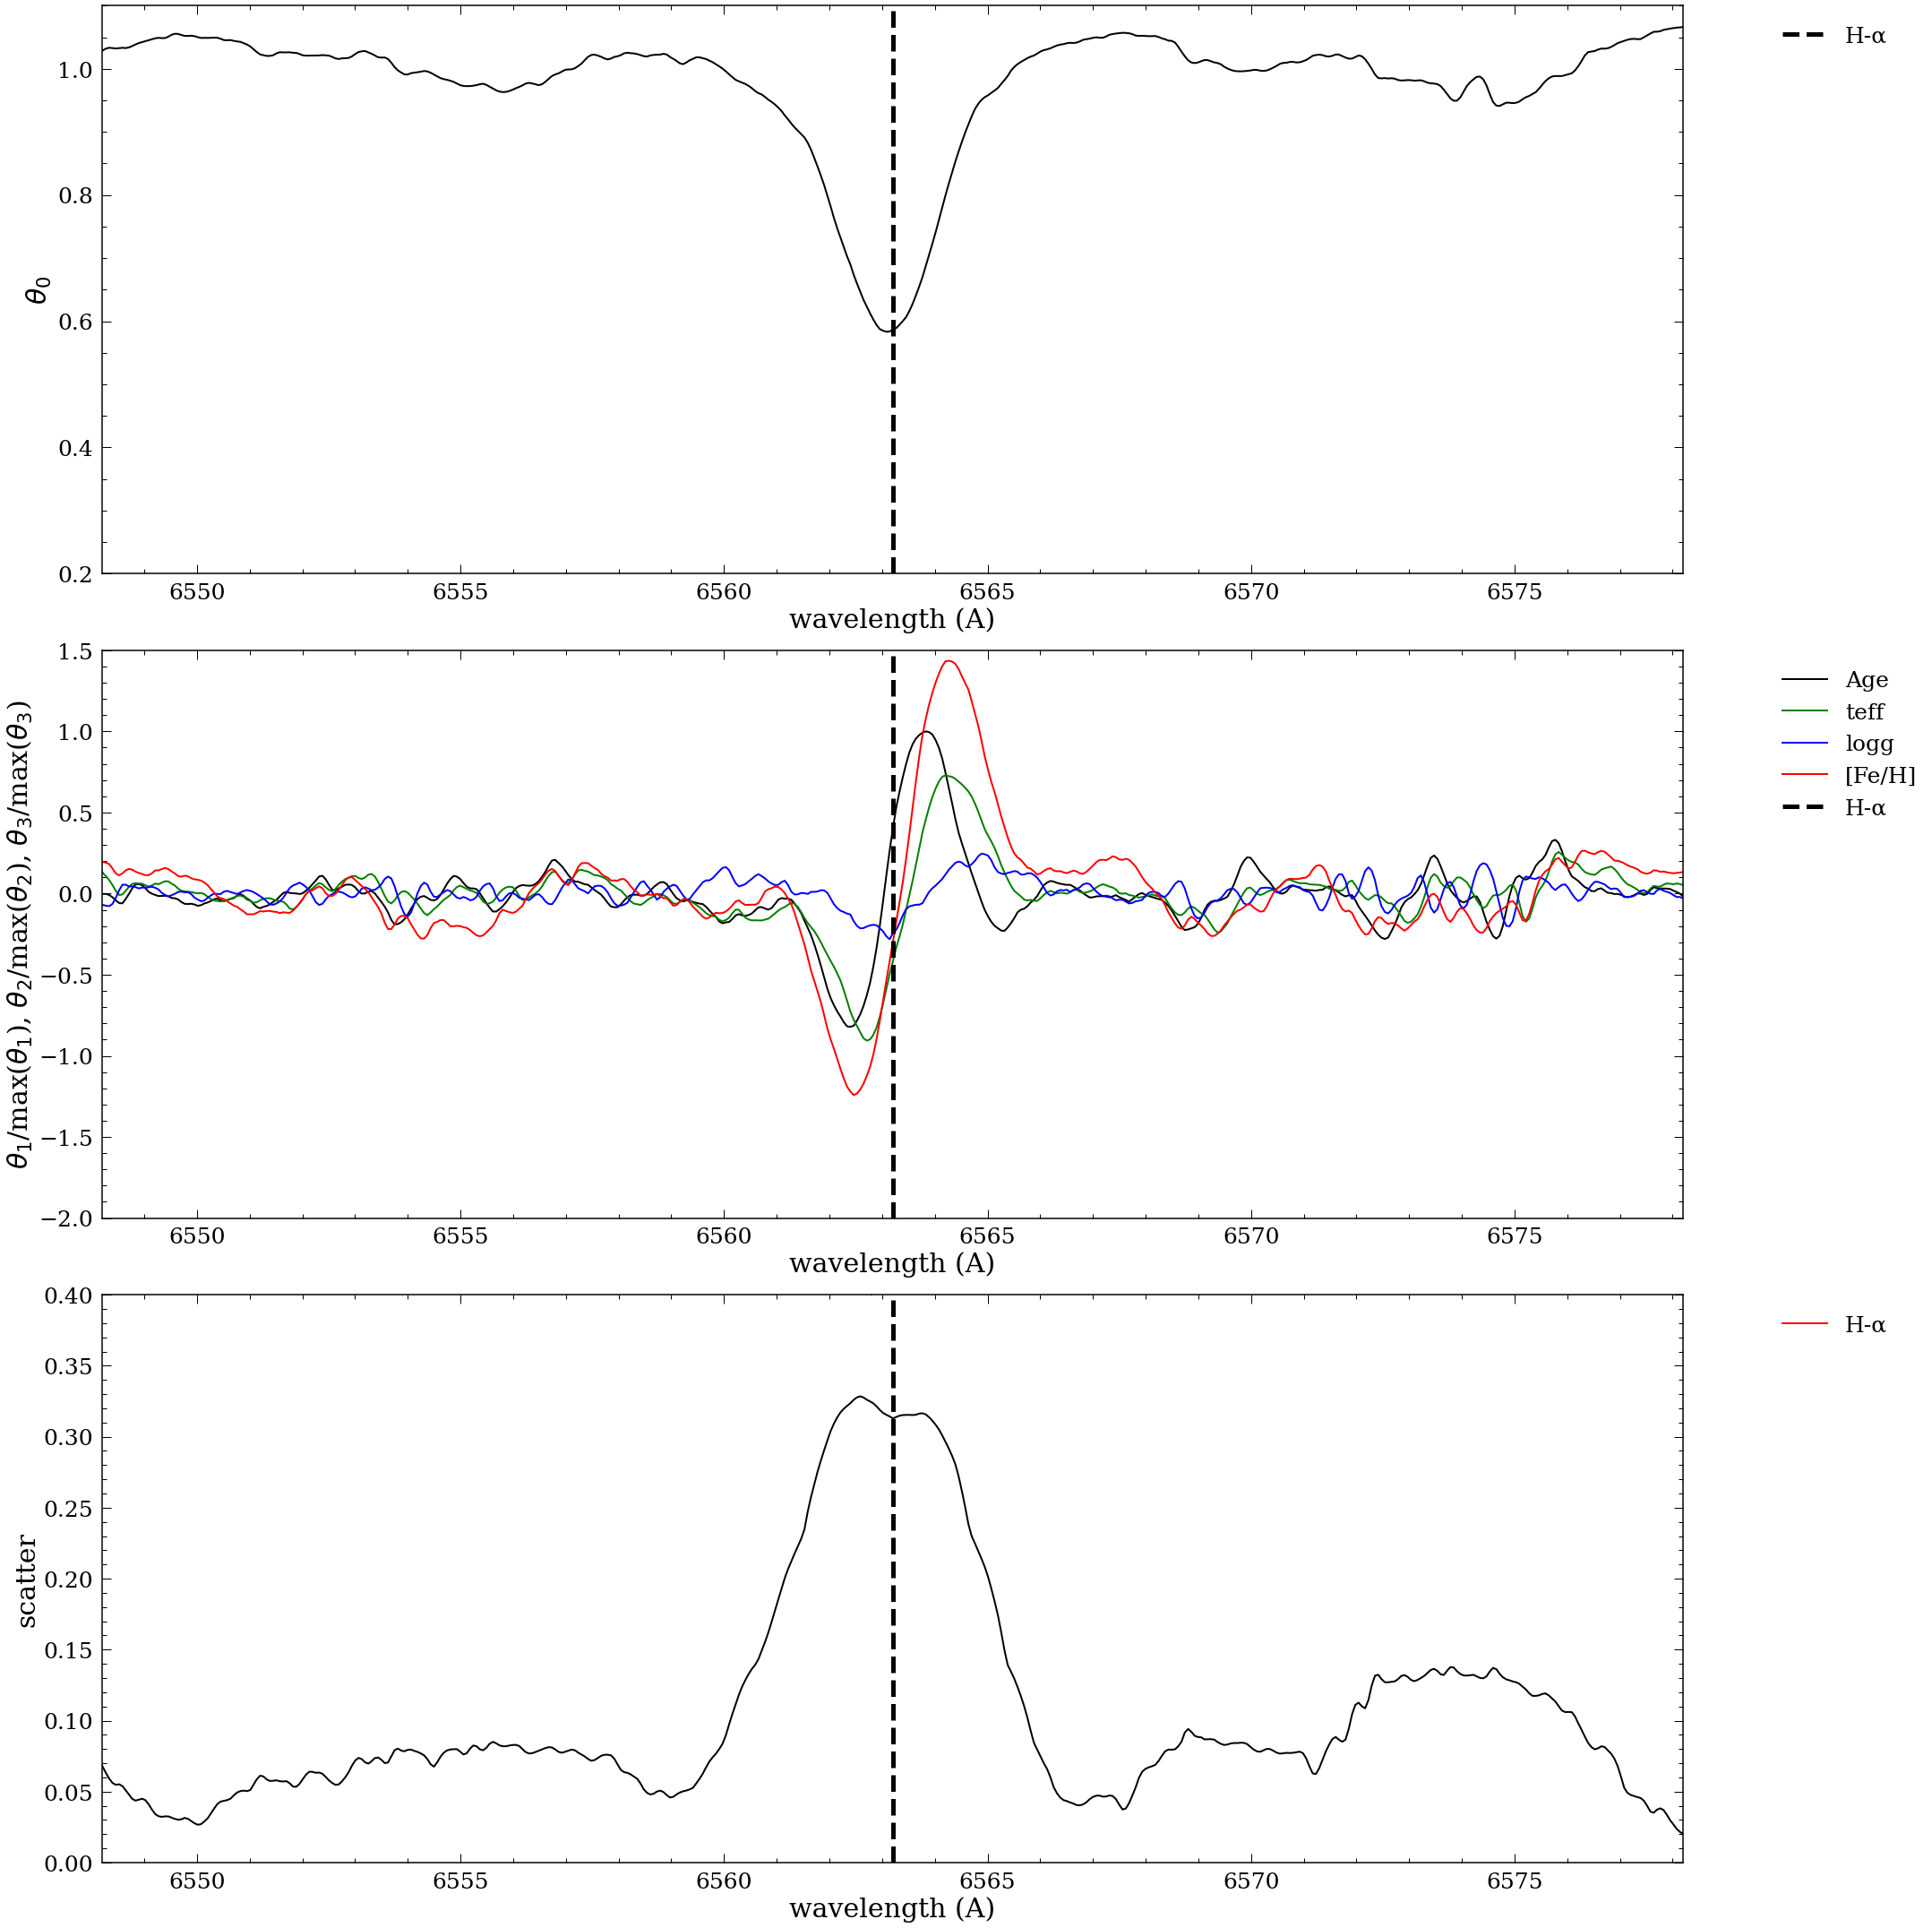

In [235]:
# focus on H-α
import matplotlib.patches as mpatches
import random

linnumb=5
wavelenghlim=[6563.2-15,6563.2+15]
#wavelenghlim=[]

plt.figure(figsize=(30,30))
plt.subplot(3,1,1)
plt.plot(wl_all[4096:4096*2],abs(coefs[:,0][4096:4096*2]),'k-')
linwl1=linlist.loc[linlist['wl2']==1].reset_index(drop=True)
elemts=linwl1.element.unique()
"""
for i in range(len(elemts)):
    linwl1_ele=linwl1.loc[linwl1['element']==elemts[i]].reset_index(drop=True)
    colorele=plt.cm.tab20(i/len(elemts))
    for j in range(len(linwl1_ele)):
        if j==0:
            rect=mpatches.Rectangle([linwl1_ele['starting wl'].iloc[j],0.7],linwl1_ele['width'].iloc[j],0.4,
                               alpha=0.8,color=colorele,label=elemts[i])
        else:
            rect=mpatches.Rectangle([linwl1_ele['starting wl'].iloc[j],0.7],linwl1_ele['width'].iloc[j],0.4,
                               alpha=0.8,color=colorele)
        plt.gca().add_patch(rect)
"""
plt.plot([6563.2,6563.2],[0.2,1.1],'k--',linewidth=5,label='H-α')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('$θ_0$')
plt.xlabel('wavelength (A)')
plt.ylim([0.2,1.1])
if len(wavelenghlim)!=0:
    plt.xlim(wavelenghlim)

plt.subplot(3,1,2)
# age
linwl1=linlist.loc[linlist['wl2']==1].reset_index(drop=True)
elemts=linwl1.element.unique()
"""
for i in range(len(elemts)):
    linwl1_ele=linwl1.loc[linwl1['element']==elemts[i]].reset_index(drop=True)
    colorele=plt.cm.tab20(i/len(elemts))
    for j in range(len(linwl1_ele)):
        if j==0:
            rect=mpatches.Rectangle([linwl1_ele['starting wl'].iloc[j],-0.1],linwl1_ele['width'].iloc[j],0.2,
                               alpha=0.8,color=colorele,label=elemts[i])
        else:
            rect=mpatches.Rectangle([linwl1_ele['starting wl'].iloc[j],-0.1],linwl1_ele['width'].iloc[j],0.2,
                               alpha=0.8,color=colorele)
        plt.gca().add_patch(rect)
"""
plt.plot(wl_all[4096:4096*2],(coefs[:,linnumb][4096:4096*2]/max(abs(coefs[:,linnumb][4096:4096*2]))),'k-',label='Age')
plt.plot(wl_all[4096:4096*2],(coefs[:,2][4096:4096*2]/max(abs(coefs[:,linnumb][4096:4096*2]))),'g-',label='teff')
plt.plot(wl_all[4096:4096*2],(coefs[:,3][4096:4096*2]/max(abs(coefs[:,linnumb][4096:4096*2]))),'b-',label='logg')
plt.plot(wl_all[4096:4096*2],(coefs[:,1][4096:4096*2]/max(abs(coefs[:,linnumb][4096:4096*2]))),'r-',label='[Fe/H]')
plt.plot([6563.2,6563.2],[-2,2],'k--',linewidth=5,label='H-α')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('$θ_1$/max($θ_1$), $θ_2$/max($θ_2$), $θ_3$/max($θ_3$)')
plt.xlabel('wavelength (A)')
plt.ylim([-2,1.5])
if len(wavelenghlim)!=0:
    plt.xlim(wavelenghlim)


plt.subplot(3,1,3)
plt.plot(wl_all[4096:4096*2],md.scatters[4096:4096*2],'k-')
linwl1=linlist.loc[linlist['wl2']==1].reset_index(drop=True)
elemts=linwl1.element.unique()
"""
for i in range(len(elemts)):
    linwl1_ele=linwl1.loc[linwl1['element']==elemts[i]].reset_index(drop=True)
    colorele=plt.cm.tab20(i/len(elemts))
    for j in range(len(linwl1_ele)):
        if j==0:
            rect=mpatches.Rectangle([linwl1_ele['starting wl'].iloc[j],0],linwl1_ele['width'].iloc[j],0.3,
                               alpha=0.8,color=colorele,label=elemts[i])
        else:
            rect=mpatches.Rectangle([linwl1_ele['starting wl'].iloc[j],0],linwl1_ele['width'].iloc[j],0.3,
                               alpha=0.8,color=colorele)
        plt.gca().add_patch(rect)
"""
plt.plot([6562.8,6562.8],[0.4,1.1],'r-',linewidth=2,label='H-α')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('scatter')
plt.xlabel('wavelength (A)')
plt.ylim([0,0.4])
plt.plot([6563.2,6563.2],[0,1],'k--',linewidth=5,label='H-α')
if len(wavelenghlim)!=0:
    plt.xlim(wavelenghlim)
    
plt.tight_layout()
plt.savefig('allwavelength2.png')


## Get all highest element coefficients

In [236]:
linlist=linlist.append({'element':'H-α','starting wl':6562.7,'endingwl':6562.9,'width':0.2}, ignore_index = True)


In [237]:
elemts=linlist['element'].unique()
agemaxcoef=np.zeros(len(elemts))
mgfemaxcoef=np.zeros(len(elemts))
fehmaxcoef=np.zeros(len(elemts))
teffmaxcoef=np.zeros(len(elemts))
loggmaxcoef=np.zeros(len(elemts))
for i in range(len(elemts)):
    listele=linlist.loc[linlist['element']==elemts[i]].reset_index(drop=True)
    for j in range(len(listele)):
        coefele=listele.iloc[j]
        m=(wl_all>=coefele['starting wl'])&(wl_all<=coefele['endingwl'])
        if sum(m)==0:
            continue
        """
        agemaxcoef[i]=max(agemaxcoef[i],max(abs(coefs[m,5])))
        mgfemaxcoef[i]=max(mgfemaxcoef[i],max(abs(coefs[m,4])))
        loggmaxcoef[i]=max(loggmaxcoef[i],max(abs(coefs[m,3])))
        teffmaxcoef[i]=max(teffmaxcoef[i],max(abs(coefs[m,2])))
        fehmaxcoef[i]=max(fehmaxcoef[i],max(abs(coefs[m,1])))
        """
        agemaxcoef[i]=agemaxcoef[i]+max(abs(coefs[m,5]))
        mgfemaxcoef[i]=mgfemaxcoef[i]+max(abs(coefs[m,4]))
        loggmaxcoef[i]=loggmaxcoef[i]+max(abs(coefs[m,3]))
        teffmaxcoef[i]=teffmaxcoef[i]+max(abs(coefs[m,2]))
        fehmaxcoef[i]=fehmaxcoef[i]+max(abs(coefs[m,1]))
    agemaxcoef[i]=agemaxcoef[i]/len(listele)
    mgfemaxcoef[i]=mgfemaxcoef[i]/len(listele)
    loggmaxcoef[i]=loggmaxcoef[i]/len(listele)
    teffmaxcoef[i]=teffmaxcoef[i]/len(listele)
    fehmaxcoef[i]=fehmaxcoef[i]/len(listele)

In [238]:
summerydata=pd.DataFrame(np.array((elemts,agemaxcoef,mgfemaxcoef,fehmaxcoef,teffmaxcoef,loggmaxcoef)).T,
                        columns=['elements','agecoef','mgfecoef','fehcoef','teffcoef','loggcoef'])

In [239]:
summerydata=summerydata.loc[(summerydata['agecoef']!=0)]

In [240]:
summerydata

elements     agecoef    mgfecoef     fehcoef    teffcoef    loggcoef
0        Al   0.0153318   0.0209641   0.0283225    0.010617  0.00870015
1        Ba    0.017271   0.0288472  0.00918625  0.00807311   0.0112195
2        Ca   0.0241906   0.0323292   0.0337644   0.0170992   0.0126299
3        Co   0.0100114    0.026335   0.0211748  0.00795408   0.0117739
4        Cr  0.00752778   0.0117189  0.00757225  0.00640414  0.00809713
5        Cu  0.00820892    0.051513   0.0208391  0.00892467    0.019227
6        Eu  0.00482271   0.0335203   0.0233131  0.00784853   0.0103012
8        La  0.00182346  0.00718635  0.00324894   0.0037143  0.00208314
9        Li  0.00913309  0.00830749  0.00701156   0.0123364    0.011953
10       Mg   0.0186941   0.0196747   0.0226127   0.0122476  0.00373505
12       Na   0.0171839   0.0228393   0.0205365     0.01572   0.0113171
13       Ni   0.0160033   0.0287316   0.0279143   0.0167114   0.0193718
14        O   0.0266148   0.0362484   0.0275597   0.0160496  0.00672139
15       Sc   0.0163449   0.0253582   0.0223311   0.0135803  0.00977146
16       Si   0.0118164   0.0257085   0.0225592   0.0101693   0.0146425
17       Ti   0.0169584   0.0282373   0.0106176  0.00577046    0.016667
18        V   0.0131645   0.0210011   0.0194534    0.011675   0.0122058
19        Y   0.0109613   0.0162999   0.0158212  0.00811665  0.00825969
21      H-α   0.0652506   0.0901436    0.116932   0.0942368   0.0211239

In [241]:
df_disp_plot=pd.read_pickle('../SecondYear/intrinsic_notemp_error_chisq.pkl')
newabd=df_disp_plot['Abund']
newabd[8]='S'
df_disp_plot['Abund']=newabd
df_disp_plot

Nesselement=['Fe','C','N','O','Na','Mg','Al','Si','S','K','Ca','Ti','V','Mn','Ni','P','Cr','Co','Rb','C/N']
Ness2019=[np.nan,0.018,-0.02,0.01,-0.031,0.01,0.011,0.004,0.002,0.007,-0.001,0.006,-0.004,-0.003,0.003,-0.012,
         -0.005,0.008,-0.002,0.038]
Ness2019_err=[np.nan,0.001,0.002,0.001,0.003,0.001,0.001,0.001,0.002,0.001,0.001,0.001,0.002,0.001,0.001,
             0.003,0.001,0.002,0.002,0.0016]
df_disp_plot=pd.merge(pd.DataFrame(np.array((Nesselement,Ness2019,Ness2019_err)).T,
                                   columns=['Abund','Ness2019','Ness2019_err']),df_disp_plot,left_on='Abund',
                     right_on='Abund',how='inner')



df_disp_plot['Ness2019']=[float(i) for i in df_disp_plot['Ness2019']]
df_disp_plot['Ness2019_err']=[float(i) for i in df_disp_plot['Ness2019_err']]
df_disp_plot

summerydata=pd.merge(summerydata,df_disp_plot,left_on='elements',right_on='Abund',how='left')
summerydata

<ipython-input-241-7c756c6ee682>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newabd[8]='S'


elements     agecoef    mgfecoef     fehcoef    teffcoef    loggcoef Abund  \
0        Al   0.0153318   0.0209641   0.0283225    0.010617  0.00870015    Al   
1        Ba    0.017271   0.0288472  0.00918625  0.00807311   0.0112195   NaN   
2        Ca   0.0241906   0.0323292   0.0337644   0.0170992   0.0126299    Ca   
3        Co   0.0100114    0.026335   0.0211748  0.00795408   0.0117739    Co   
4        Cr  0.00752778   0.0117189  0.00757225  0.00640414  0.00809713    Cr   
5        Cu  0.00820892    0.051513   0.0208391  0.00892467    0.019227   NaN   
6        Eu  0.00482271   0.0335203   0.0233131  0.00784853   0.0103012   NaN   
7        La  0.00182346  0.00718635  0.00324894   0.0037143  0.00208314   NaN   
8        Li  0.00913309  0.00830749  0.00701156   0.0123364    0.011953   NaN   
9        Mg   0.0186941   0.0196747   0.0226127   0.0122476  0.00373505    Mg   
10       Na   0.0171839   0.0228393   0.0205365     0.01572   0.0113171    Na   
11       Ni   0.0160033   0.0287316   0.0279143   0.0167114   0.0193718    Ni   
12        O   0.0266148   0.0362484   0.0275597   0.0160496  0.00672139     O   
13       Sc   0.0163449   0.0253582   0.0223311   0.0135803  0.00977146   NaN   
14       Si   0.0118164   0.0257085   0.0225592   0.0101693   0.0146425    Si   
15       Ti   0.0169584   0.0282373   0.0106176  0.00577046    0.016667    Ti   
16        V   0.0131645   0.0210011   0.0194534    0.011675   0.0122058     V   
17        Y   0.0109613   0.0162999   0.0158212  0.00811665  0.00825969   NaN   
18      H-α   0.0652506   0.0901436    0.116932   0.0942368   0.0211239   NaN   

    Ness2019  Ness2019_err  la_dis_astro  ...   ha_grad  ha_grad_err  \
0      0.011         0.001      0.037635  ... -0.007581     0.005410   
1        NaN           NaN           NaN  ...       NaN          NaN   
2     -0.001         0.001      0.020024  ... -0.002099     0.003274   
3      0.008         0.002      0.064498  ... -0.001095     0.009730   
4     -0.005         0.001      0.050328  ... -0.003640     0.009170   
5        NaN           NaN           NaN  ...       NaN          NaN   
6        NaN           NaN           NaN  ...       NaN          NaN   
7        NaN           NaN           NaN  ...       NaN          NaN   
8        NaN           NaN           NaN  ...       NaN          NaN   
9      0.010         0.001      0.026476  ... -0.001257     0.003055   
10    -0.031         0.003      0.111248  ... -0.021804     0.013792   
11     0.003         0.001      0.019517  ... -0.000683     0.003079   
12     0.010         0.001      0.032056  ...  0.001475     0.003915   
13       NaN           NaN           NaN  ...       NaN          NaN   
14     0.004         0.001      0.020087  ... -0.000205     0.002550   
15     0.006         0.001      0.032541  ... -0.000179     0.004709   
16    -0.004         0.002      0.124561  ... -0.015395     0.012710   
17       NaN           NaN           NaN  ...       NaN          NaN   
18       NaN           NaN           NaN  ...       NaN          NaN   

        diff  Species       m   m_err       s   s_err ha_err_all  la_err_all  
0   0.009071       Al  0.0139  0.0010  0.0156  0.0019   0.009118    0.010033  
1        NaN      NaN     NaN     NaN     NaN     NaN        NaN         NaN  
2   0.001546       Ca -0.0005  0.0000  0.0089  0.0011   0.011095    0.011345  
3   0.003407       Co  0.0074  0.0011  0.0178  0.0020   0.010172    0.010550  
4   0.001289      NaN     NaN     NaN     NaN     NaN   0.027342    0.027617  
5        NaN      NaN     NaN     NaN     NaN     NaN        NaN         NaN  
6        NaN      NaN     NaN     NaN     NaN     NaN        NaN         NaN  
7        NaN      NaN     NaN     NaN     NaN     NaN        NaN         NaN  
8        NaN      NaN     NaN     NaN     NaN     NaN        NaN         NaN  
9   0.008991       Mg  0.0099  0.0009  0.0121  0.0018   0.014634    0.015826  
10  0.006869       Na  0.0086  0.0016  0.0273  0.0029   0.011333    0.01

Text(0.5, 1.0, 'logg')

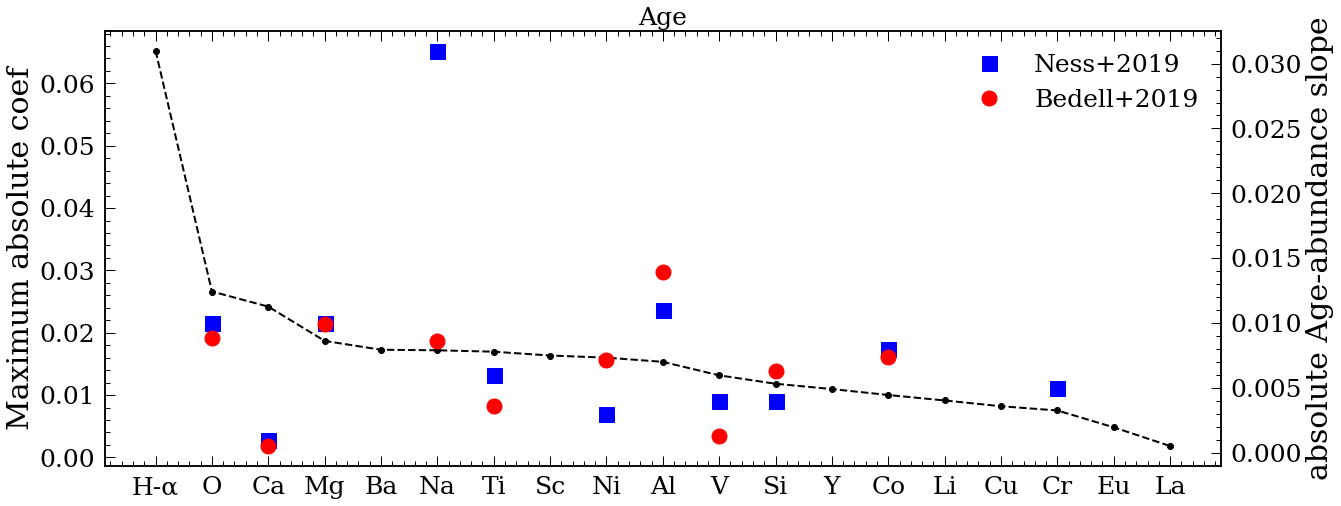

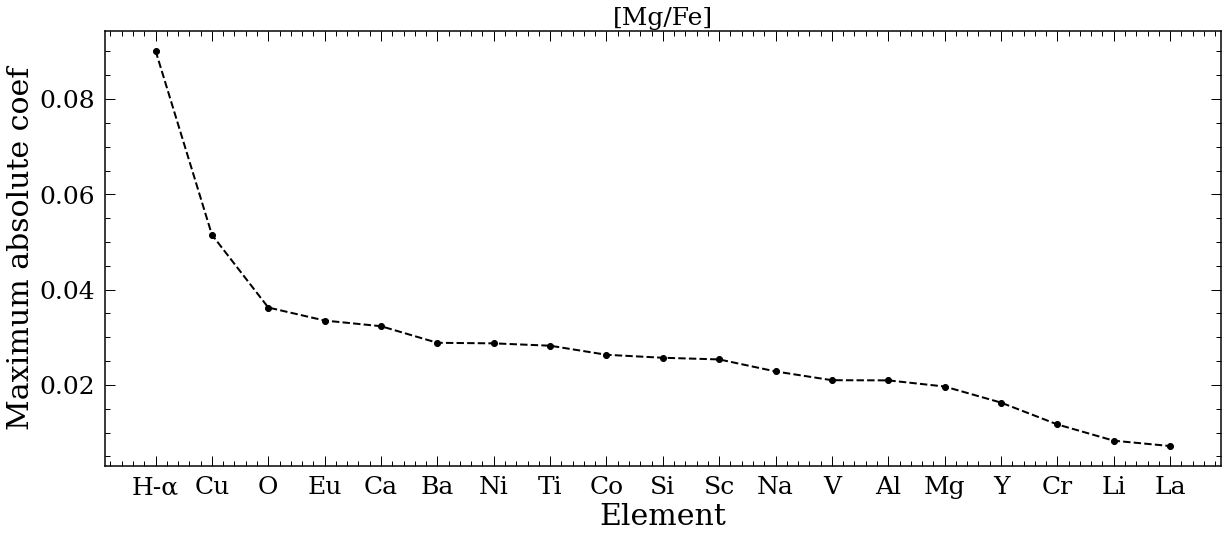

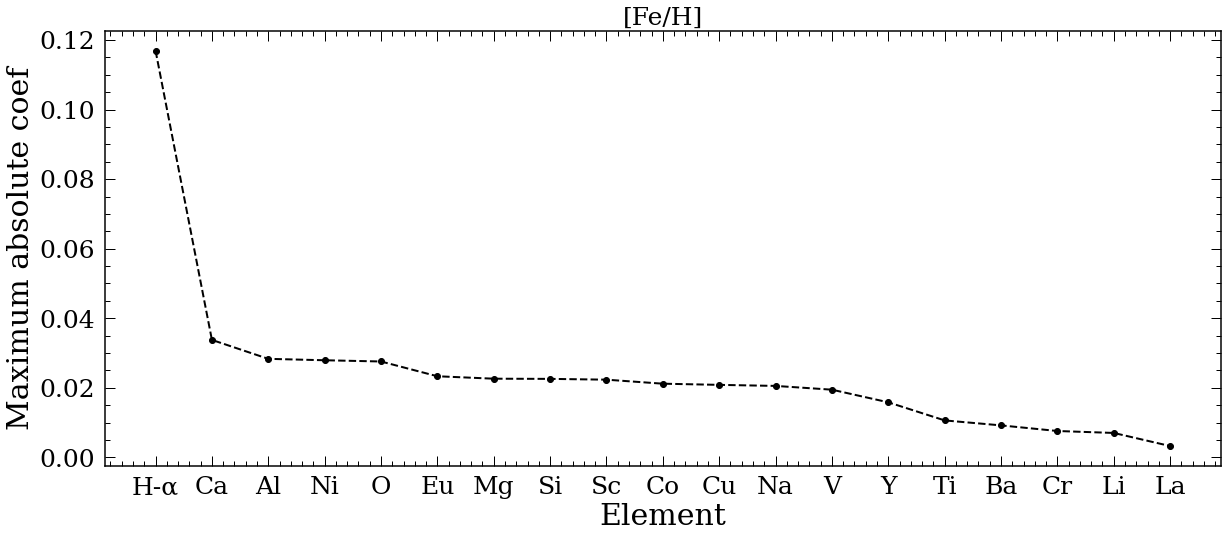

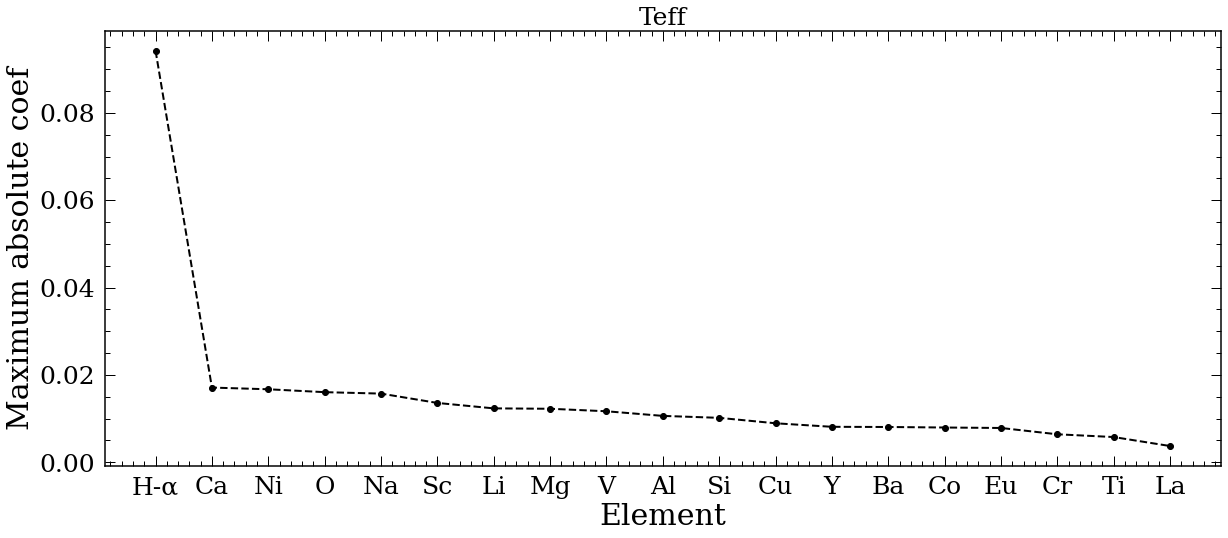

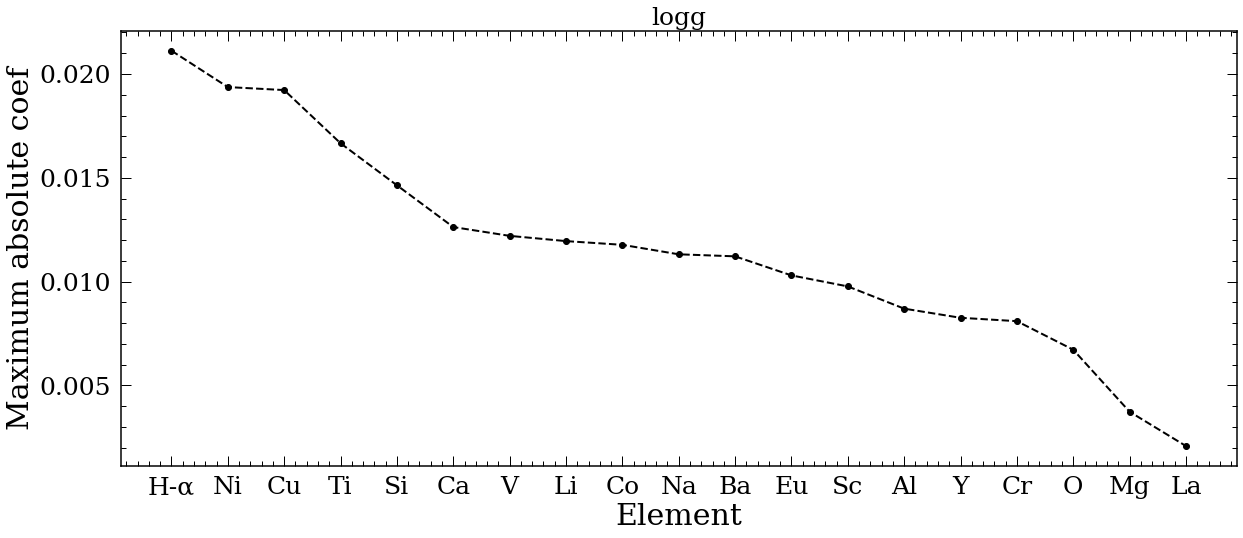

In [242]:


plt.figure(figsize=(20,8))
summerydata=summerydata.sort_values(by='agecoef',ascending=False)
plt.plot(summerydata['elements'],summerydata['agecoef'],'ko--',label='Age')
plt.ylabel('Maximum absolute coef')
plt.twinx()
plt.plot(summerydata['elements'],abs(summerydata['Ness2019']),'bs',label='Ness+2019',markersize=15)
plt.plot(summerydata['elements'],abs(summerydata['m']),'ro',label='Bedell+2019',markersize=15)
plt.ylabel('absolute Age-abundance slope')
plt.xlabel('Element')
plt.title('Age',fontsize=25)
plt.legend(loc=1)

plt.figure(figsize=(20,8))
summerydata=summerydata.sort_values(by='mgfecoef',ascending=False)
plt.plot(summerydata['elements'],summerydata['mgfecoef'],'ko--',label='[Mg/Fe]')
plt.ylabel('Maximum absolute coef')
plt.xlabel('Element')
plt.title('[Mg/Fe]',fontsize=25)

plt.figure(figsize=(20,8))
summerydata=summerydata.sort_values(by='fehcoef',ascending=False)
plt.plot(summerydata['elements'],summerydata['fehcoef'],'ko--',label='[Fe/H]')
plt.ylabel('Maximum absolute coef')
plt.xlabel('Element')
plt.title('[Fe/H]',fontsize=25)

plt.figure(figsize=(20,8))
summerydata=summerydata.sort_values(by='teffcoef',ascending=False)
plt.plot(summerydata['elements'],summerydata['teffcoef'],'ko--',label='Teff')
plt.ylabel('Maximum absolute coef')
plt.xlabel('Element')
plt.title('Teff',fontsize=25)

plt.figure(figsize=(20,8))
summerydata=summerydata.sort_values(by='loggcoef',ascending=False)
plt.plot(summerydata['elements'],summerydata['loggcoef'],'ko--',label='logg')
plt.ylabel('Maximum absolute coef')
plt.xlabel('Element')
plt.title('logg',fontsize=25)

# Get all GALAH ages

In [243]:
import scipy.optimize as opt
def _infer_labels(model, nlabels, flux, ivar, starting_guess=None):
    coeffs_all = model.coeffs
    scatters = model.scatters
    errs_all = np.zeros(nlabels)
    chisq_all = 0
    scales = model.scales

    if starting_guess is None:
        starting_guess = np.ones(nlabels)

    bad = ivar == 0
    flux[bad] = 1.0
    sigma = np.ones(ivar.shape) * 100.0
    sigma[~bad] = np.sqrt(1.0 / ivar[~bad])

    flux_piv = flux - coeffs_all[:,0] * 1.  # pivot around the leading term
    errbar = np.sqrt(sigma**2 + scatters**2)
    coeffs = np.delete(coeffs_all, 0, axis=1)  # take pivot into account
        
    try:
        labels, covs = opt.curve_fit(_func, coeffs, flux_piv,
                                         p0 = starting_guess,
                                         sigma=errbar, absolute_sigma=True)
    except RuntimeError:
        print("Error - curve_fit failed")
        labels = np.zeros(starting_guess.shape)-9999.
        covs = np.zeros((len(starting_guess),len(starting_guess)))-9999.
    chi2 = (flux_piv-_func(coeffs, *labels))**2 * ivar / (1 + ivar * scatters**2)
    chisq_all = sum(chi2)
    labels_all = model.scales * labels + model.pivots
    errs_all = np.sqrt(covs.diagonal())

    return labels_all, errs_all, chisq_all

def _func(coeffs, *labels):
    """ Takes the dot product of coefficients vec & labels vector 
    
    Parameters
    ----------
    coeffs: numpy ndarray
        the coefficients on each element of the label vector

    *labels: numpy ndarray
        label vector

    Returns
    -------
    dot product of coeffs vec and labels vec
    """
    lvec = _get_lvec(list(labels))
    return np.dot(coeffs, lvec)


def _get_lvec(labels):
    """
    Constructs a label vector for an arbitrary number of labels
    Assumes that our model is quadratic in the labels

    Parameters
    ----------
    labels: numpy ndarray
        pivoted label values for one star

    Returns
    -------
    lvec: numpy ndarray
        label vector
    """
    nlabels = len(labels)
    # specialized to second-order model
    linear_terms = labels 
    quadratic_terms = np.outer(linear_terms, 
                               linear_terms)[np.triu_indices(nlabels)]
    lvec = np.hstack((linear_terms, quadratic_terms))
    return lvec

In [244]:
import glob
files=glob.glob("/Users/yl4331/Desktop/CreateDataTable/Data/galahages/dr3/spectra/hermes/*.fits")

In [245]:
files[0][-21:-6]

'150407001601089'

In [246]:
sobid=[i[-21:-6] for i in files]

In [ ]:
fluxs=np.zeros((4096,4))
ivars=np.zeros((4096,4))

allwl=np.zeros(4096*4)
for i in range(4):
    allwl[4096*i:4096*(i+1)]=wl[:,i]
m=(allwl<7586)|(allwl>7700)
m=m&(allwl>5000)
allwl=allwl[m]

f = open("galahages_nooutlier", "w")
f.write('sobid,feh,feh_err,teff,teff_err,logg,logg_err,mg_fe,mg_fe_err,age,age_err,chisq,SNR\n')
    
for i in trange(len(sobid)):
    spname='/Users/yl4331/Desktop/CreateDataTable/Data/galahages/dr3/spectra/hermes/'
    count=0
    
    wstr=sobid[i]+','
    # see if I have complete data
    for j in range(4):
        # read in spectra
        newspname=spname+sobid[i]+str(j+1)+'.fits'
        
        # get what the old wl is
        try:
            data=fits.open(newspname)[0]
            try:
                wl_old=np.linspace(data.header['CRVAL1'],data.header['CDELT1']*len(data.data)+data.header['CRVAL1'],len(data.data))
                
                # get old flux/ivar
                flux=fits.open(newspname)[0].data # load in unnormalized flux
                ivar=fits.open(newspname)[1].data*flux # load in ivar
            
                __, new_flux = interpolate_to_grid(wl_old, flux, wl[:,j]) # on common grid
                __, new_ivar = interpolate_to_grid(wl_old, ivar, wl[:,j]) # on common grid
                count=count+1
            except:
                continue
        except:
            continue
            
        
    
    fluxall=np.zeros(4096*4)
    ivarsall=np.zeros(4096*4)
    if count==4:
        for j in range(4):
            newspname=spname+sobid[i]+str(j+1)+'.fits'
            data=fits.open(newspname)[0]
            wl_old=np.linspace(data.header['CRVAL1'],data.header['CDELT1']*len(data.data)+data.header['CRVAL1'],len(data.data))
         
            # get old flux/ivar
            flux=fits.open(newspname)[0].data # load in unnormalized flux
            ivar=fits.open(newspname)[1].data*flux # load in ivar
            
            __, new_flux = interpolate_to_grid(wl_old, flux, wl[:,j]) # on common grid
            __, new_ivar = interpolate_to_grid(wl_old, ivar, wl[:,j]) # on common grid
        
            normflux=scipy.ndimage.gaussian_filter1d(new_flux, 300)
            flux_norm = new_flux/normflux # normalize flux
            ivar_norm = 1./(new_ivar/normflux)**2 # normalize ivar
            #fluxall[4096*j:4096*(j+1)],ivarsall[4096*j:4096*(j+1)]=replace_outliers(flux_norm,ivar_norm, softenp=10, f=3)
    
        fluxall,ivarsall=fluxall[m],ivarsall[m]
        
        labels_all, errs_all, chisq_all=_infer_labels(md, 5, fluxall, ivarsall)
        SNR_sing=calc_SNR(fluxall, ivarsall)
        
        for k in range(len(labels_all)):
            wstr=wstr+str(labels_all[k])+','+str(errs_all[k])+','
        wstr=wstr+str(chisq_all)+','+str(SNR_sing)+'\n'
        f.write(wstr)       
    else:
        for k in range(11):
            wstr=wstr+str(-9999)+','
        wstr=wstr+str(-9999)+'\n'
        f.write(wstr)      
        

  5%|▌         | 15209/298067 [24:33<7:15:56, 10.81it/s] 

In [36]:
allages=pd.read_table('galahages',delimiter=',')


In [37]:
print(len(allages))
allages=allages.loc[allages['SNR']>40].reset_index(drop=True)
print(len(allages))

298051
182767
